# Kaggle Mercedes Challenge

### Libraries

In [1892]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
#import bokeh.plotting as bp
#import bokeh.charts as bc
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
from sklearn import linear_model, decomposition
from math import log, exp
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from pandas.plotting import scatter_matrix

#from scipy import stats
#from scipy.special import boxcox, inv_boxcox



%matplotlib inline
#bp.output_notebook()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

### Data Import and exploration

In [1893]:
train = pd.read_csv('./data/train.csv')
testing = pd.read_csv('./data/test.csv')

In [1894]:
train.shape

(4209, 378)

In [1895]:
testing.shape

(4209, 377)

In [1896]:
##extract testing IDs for later use
testing_ID = testing['ID']

In [1897]:
#cols = train.columns.values
#plot = 1 
#for col in cols:
#    plt.figure(plot)
#    plt.scatter(y= train['y'], x= train[col])
#    plt.title(col)
#    plot+=1

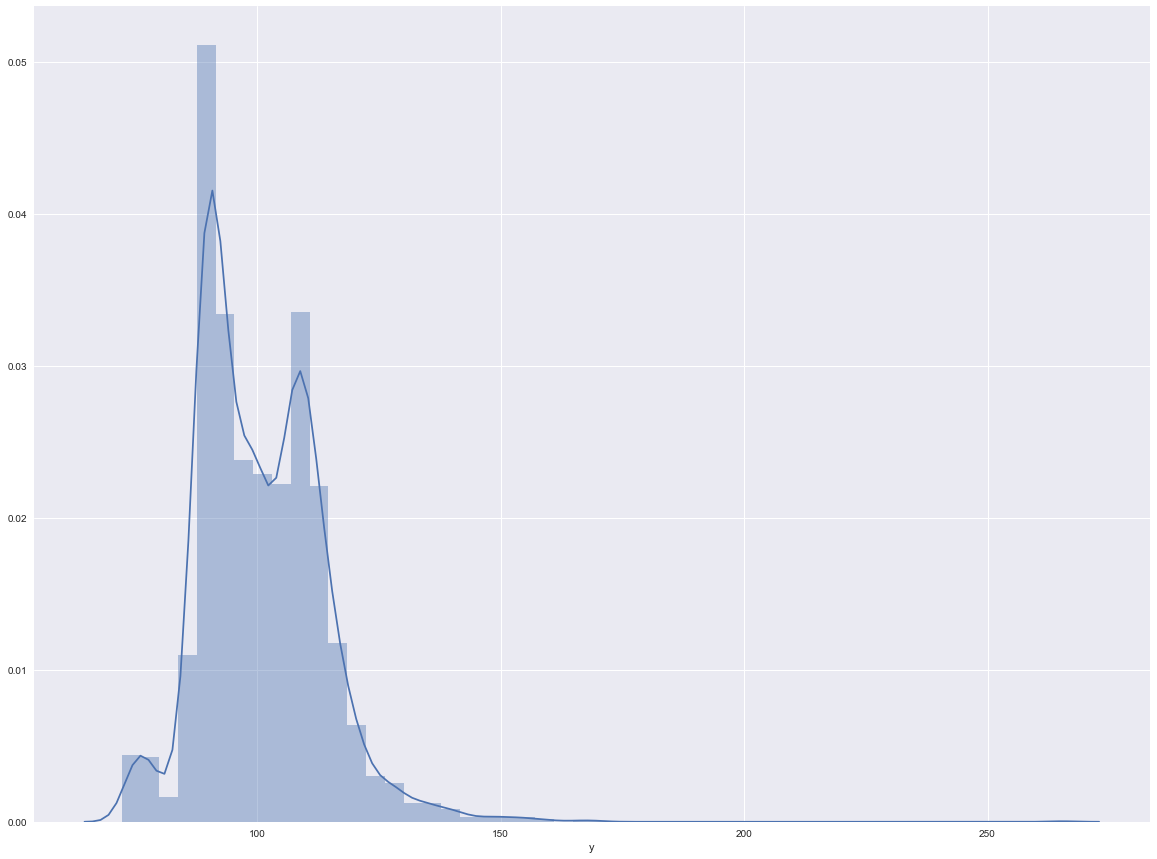

In [1898]:
plt.figure(figsize =(20,15))
sns.distplot(train['y'])

#### X0 categories

Got this idea from Marcel Spitzer - Biased predictions - How to deal with them?     
https://www.kaggle.com/msp48731/biased-predictions-how-to-deal-with-them

Looks like there is a clear grouping of X0 values into approximately 4 groups, maybe 5 is we put aa in it's own category.  This might be useful in building prediction models based on group or perhaps just by adding a group feature or mean value as feature.  

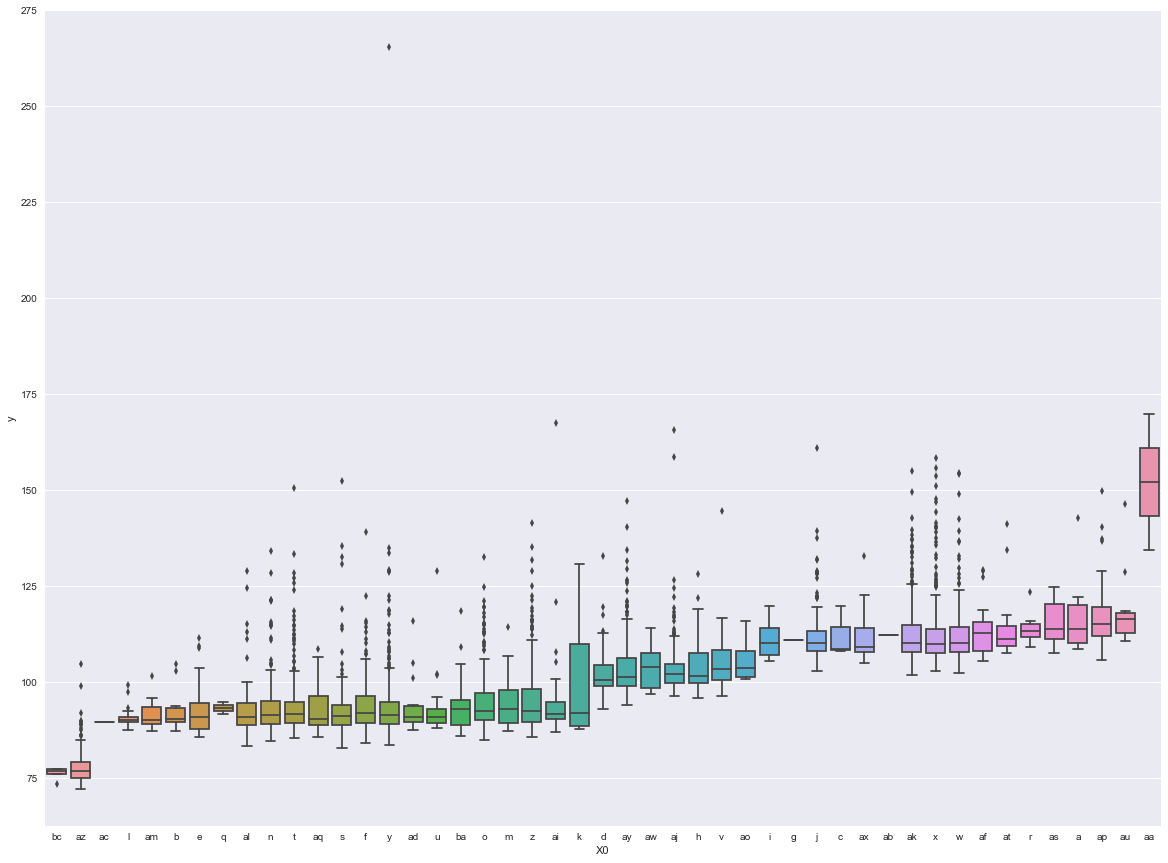

In [1899]:
y_sort_X0 = train.groupby('X0').mean().sort_values('y').index

plt.figure(figsize =(20,15))
ax = sns.boxplot(x="X0", y="y", data=train, order=y_sort_X0)

In [1900]:
group_1 = ["bc","az"]
group_2 = ["ac","am","l","b","aq","u","ad","e","al","s","n","y","t","ai","k","f","z","o","ba","m","q"]
group_3 = ["d","ay","h","aj","v","ao","aw"]
group_4 = ["c","ax","x","j","w","i","ak","g","at","ab","af","r","as","a","ap","au"]
group_5 = ['aa']

group_dict = {}
for grp in group_1:
    group_dict[grp] = 1
for grp in group_2:
    group_dict[grp] = 2
for grp in group_3:
    group_dict[grp] = 3
for grp in group_4:
    group_dict[grp] = 4
for grp in group_5:
    group_dict[grp] = 5
    
##values that only exist in test
group_dict['av'] = 0
group_dict['ag'] = 0
group_dict['an'] = 0
group_dict['ae'] = 0
group_dict['p'] = 0
group_dict['bb'] = 0

X0_testonly = ['av','ag','an','ae','p','bb']

#### X1 

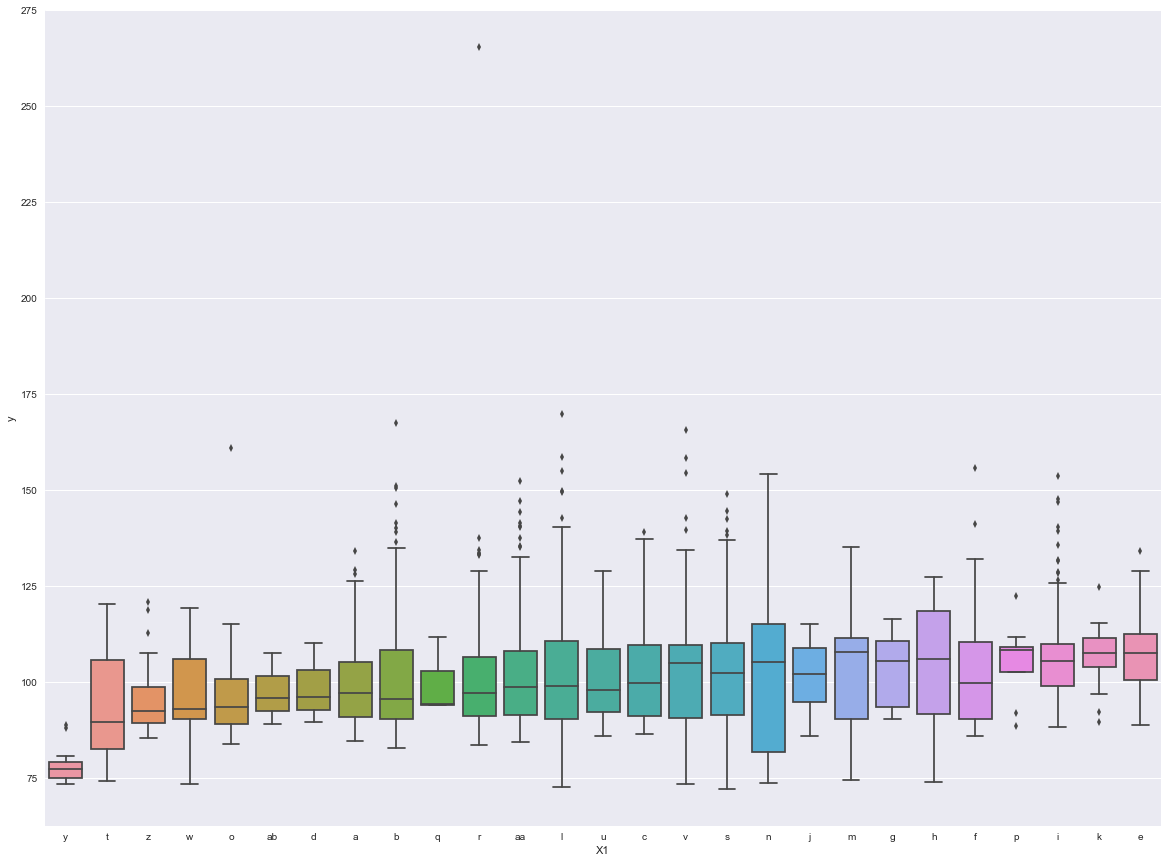

In [1901]:
y_sort_X1 = train.groupby('X1').mean().sort_values('y').index

plt.figure(figsize =(20,15))
ax = sns.boxplot(x="X1", y="y", data=train, order=y_sort_X1)

#### X2 

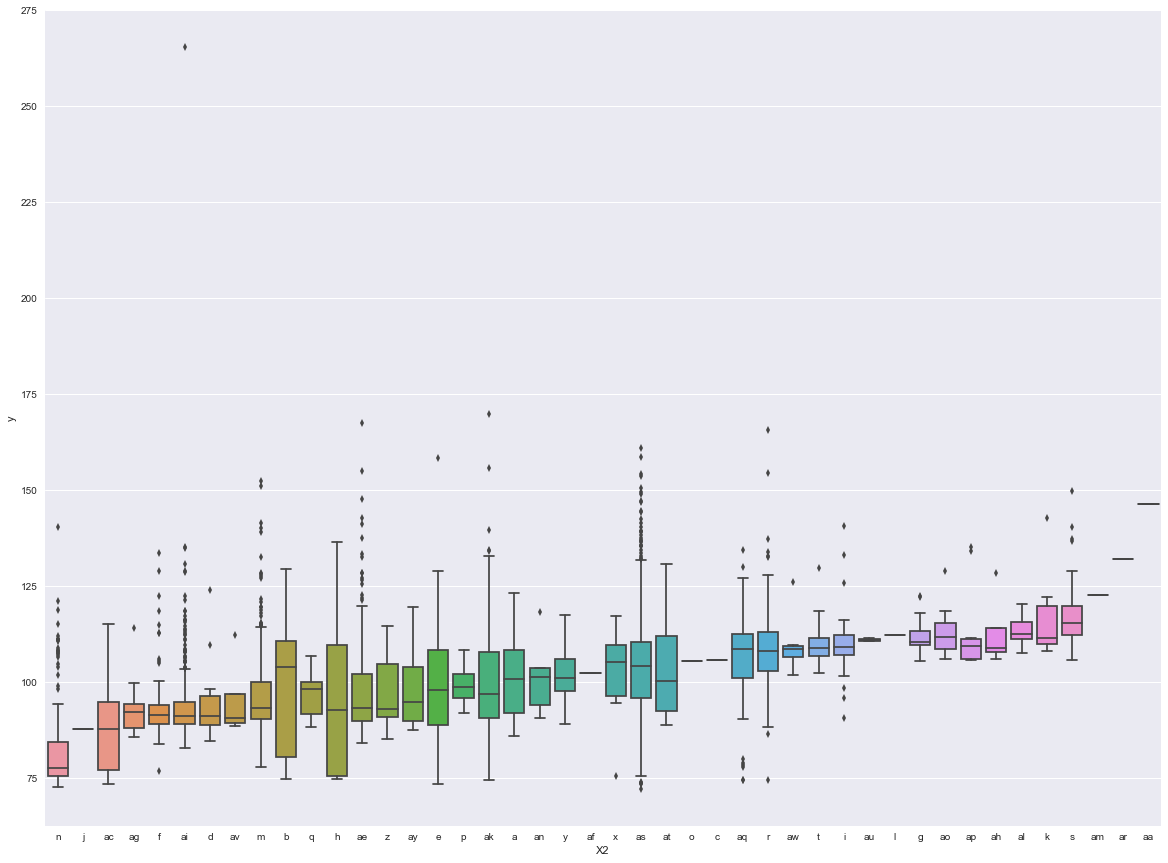

In [1902]:
y_sort_X2 = train.groupby('X2').mean().sort_values('y').index

plt.figure(figsize =(20,15))
ax = sns.boxplot(x="X2", y="y", data=train, order=y_sort_X2)

#### X3

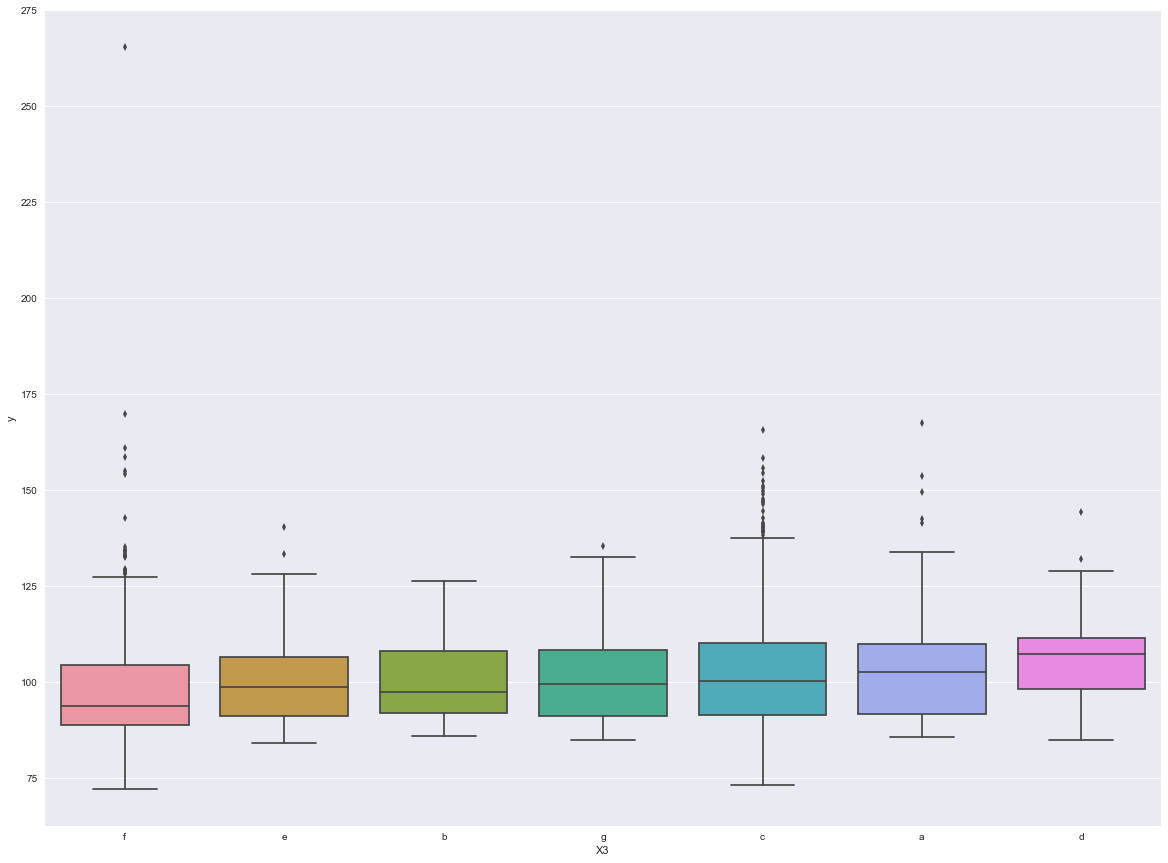

In [1903]:
y_sort_X3 = train.groupby('X3').mean().sort_values('y').index

plt.figure(figsize =(20,15))
ax = sns.boxplot(x="X3", y="y", data=train, order=y_sort_X3)

#### X4

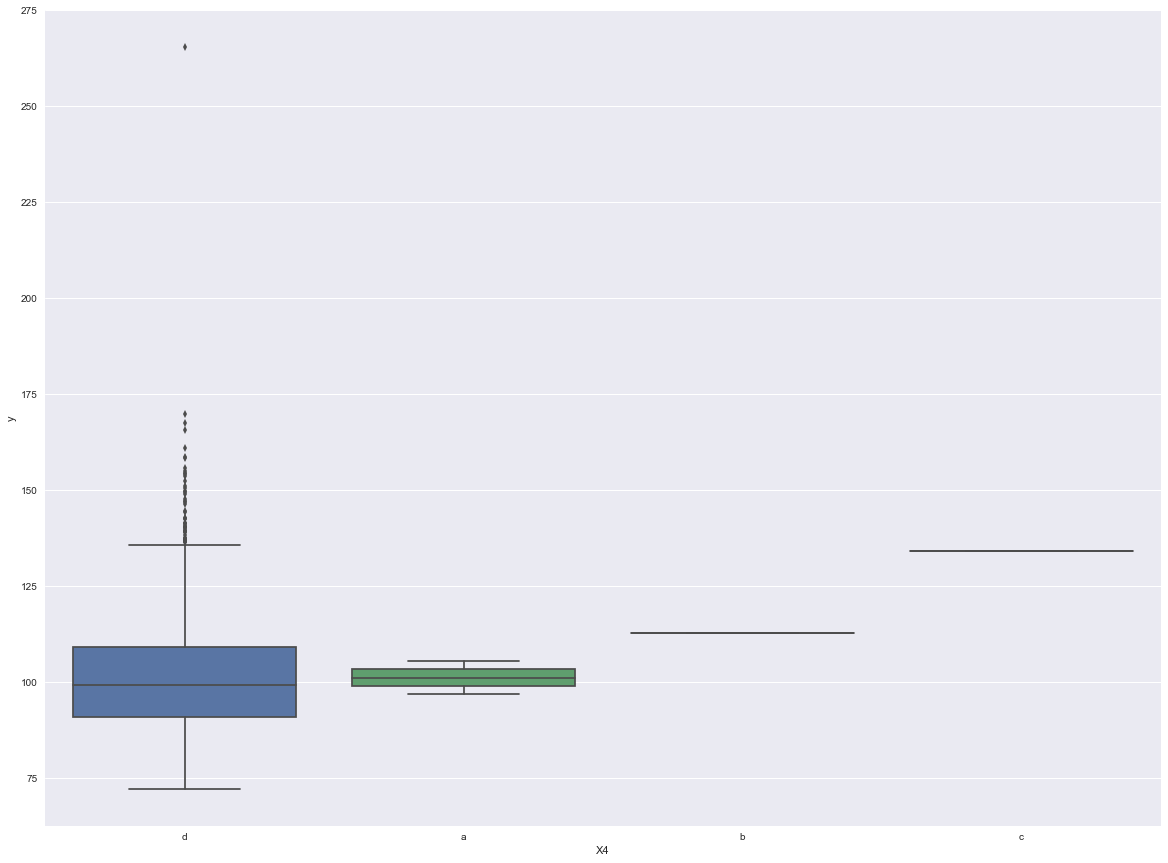

In [1904]:
y_sort_X4 = train.groupby('X4').mean().sort_values('y').index

plt.figure(figsize =(20,15))
ax = sns.boxplot(x="X4", y="y", data=train, order=y_sort_X4)

#### X5

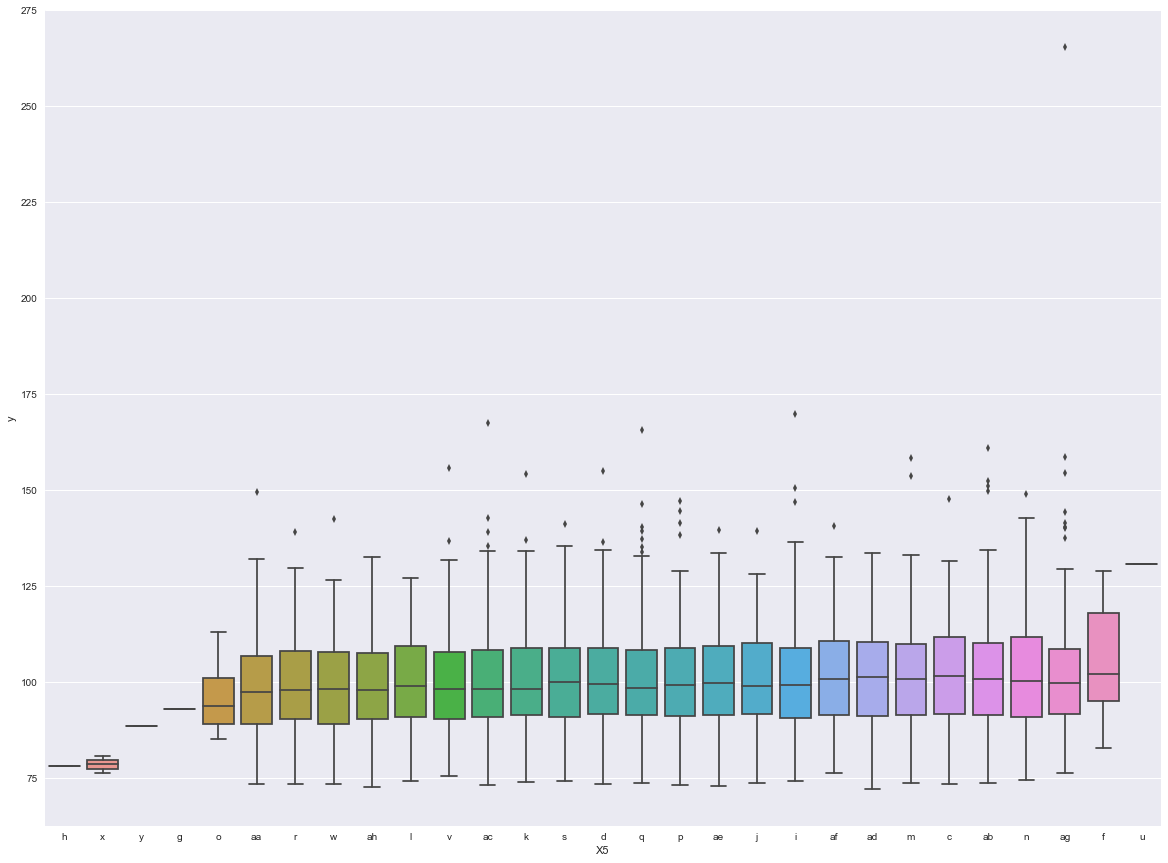

In [1905]:
y_sort_X5 = train.groupby('X5').mean().sort_values('y').index

plt.figure(figsize =(20,15))
ax = sns.boxplot(x="X5", y="y", data=train, order=y_sort_X5)

#### X6

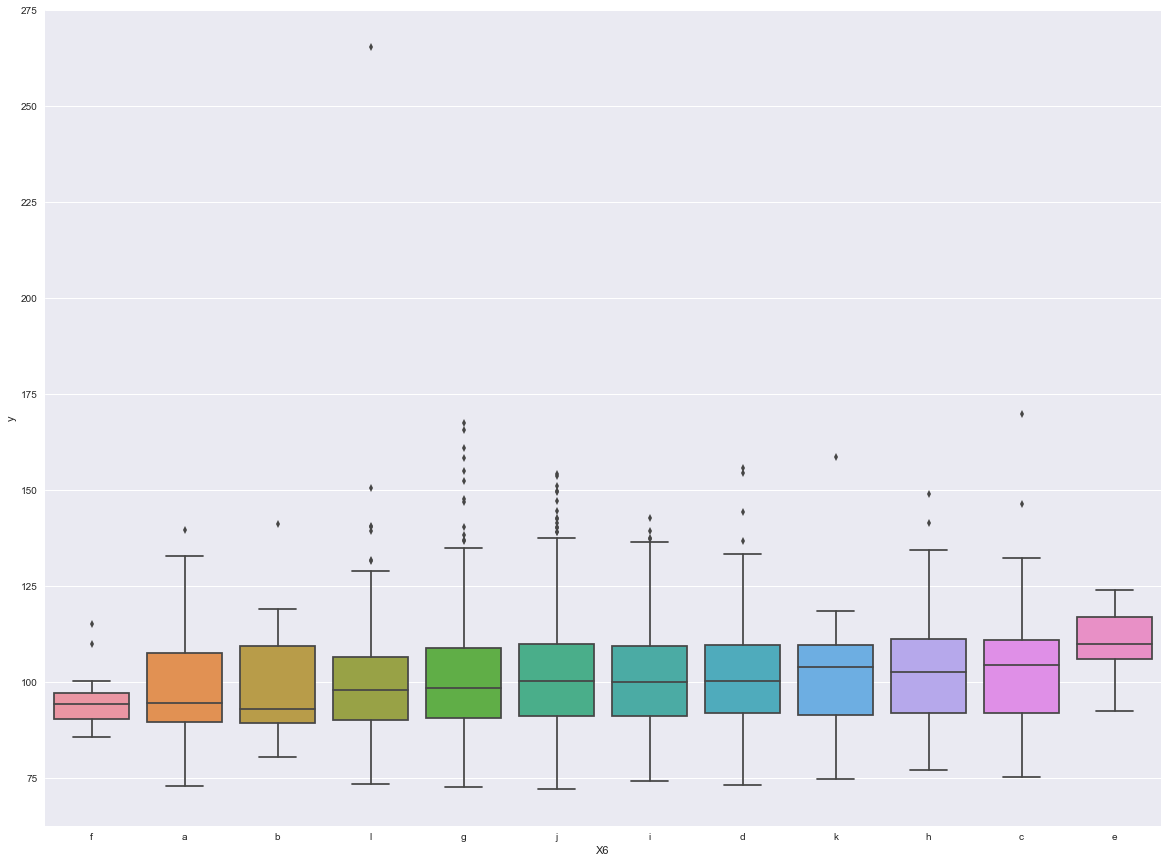

In [1906]:
y_sort_X6 = train.groupby('X6').mean().sort_values('y').index

plt.figure(figsize =(20,15))
ax = sns.boxplot(x="X6", y="y", data=train, order=y_sort_X6)

#### X8

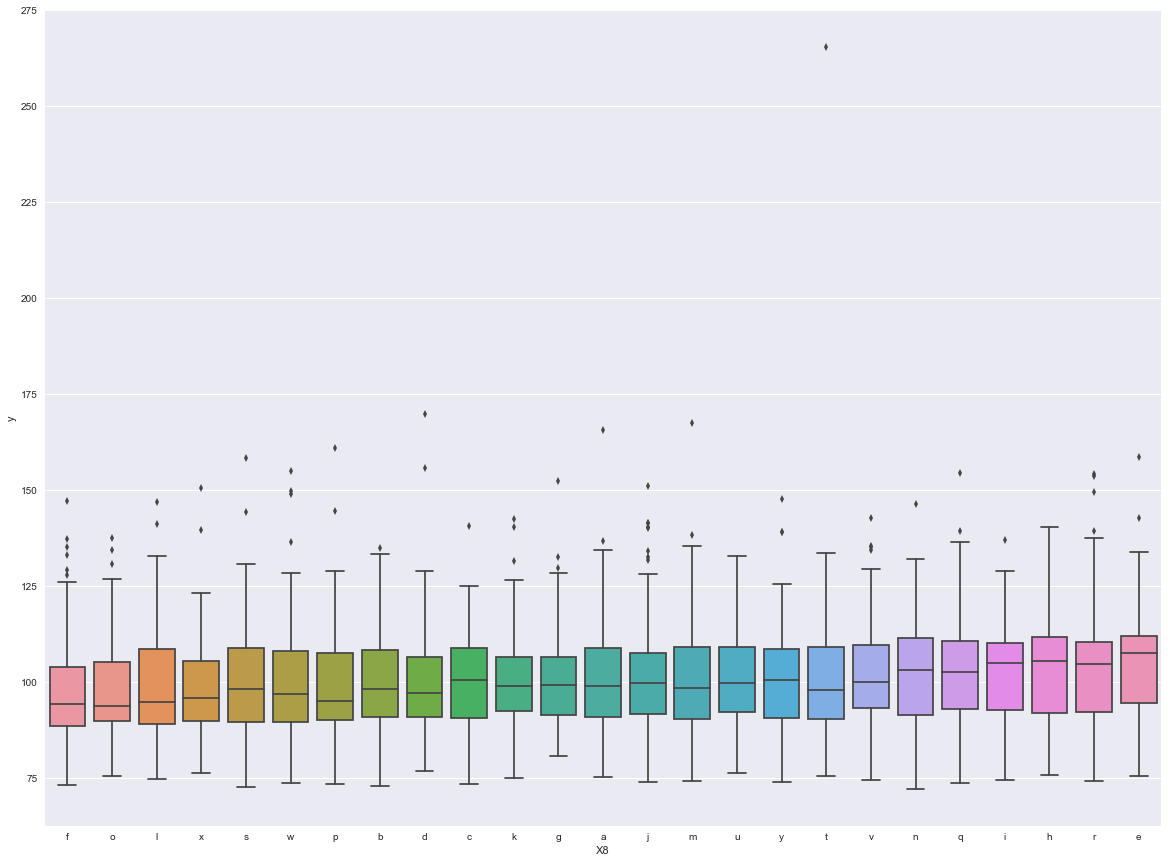

In [1907]:
y_sort_X8 = train.groupby('X8').mean().sort_values('y').index

plt.figure(figsize =(20,15))
ax = sns.boxplot(x="X8", y="y", data=train, order=y_sort_X8)

### Encode categorical variables and add features

In [1908]:
##hack to prevent sorting of columns during append.
testing.insert(1,'y','0')
testing['y'] = testing['y'].astype('float64')

## combine data for label encoding
all_data = train.append(testing,ignore_index=True)

#### add X0_group as a feature

In [1909]:
X0 = all_data['X0'].values
X0_group = []

for x in X0:
    X0_group = np.append(X0_group,group_dict[x]).astype('int')
    
all_data['X0_group'] = X0_group

In [1910]:
#plt.figure(figsize =(20,15))
#ax = sns.boxplot(x='X0_group', y='y', data=train)

In [1911]:
#train_X0_group2 = train[train['X0_group']==2]
#outliers_group2 = train_X0_group2[train_X0_group2['y']>105]
#outliers_group2.describe()

#### outlier metric as feature?

In [1912]:
def count_outliers(X, std_dev_thresh):

    outlier_counts = {}
    groups = train[X].unique()
    

    for group in groups:
    
        ##initialize some variables for the group
        grp_index = train[train[X]==group].index
        grp_std = train.loc[grp_index].y.std()
        grp_mean = train.loc[grp_index].y.mean()
        y_thresh = grp_mean + (std_dev_thresh * grp_std)
    
        ##count outliers
        count = 0 
        y_values=train.loc[grp_index,'y']
    
        for y in y_values:
            if y > y_thresh:
                count += 1

        outlier_counts[group] = count
    
    return outlier_counts


In [1913]:
to_count = ['X0', 'X1', 'X2', 'X3', 'X5', 'X6', 'X8']
std_dev_thresh = 3
counts = {}

for feat in to_count:
    counts[feat] = count_outliers(feat, std_dev_thresh)
    

In [1914]:
all_data_subset = all_data[to_count].copy()

for feat in to_count:
    values = all_data_subset[feat]
    new_values = []
    
    for value in values:
        nv = counts.get(feat,0).get(value,0)
        new_values = np.append(new_values,nv)
        
    all_data_subset[feat] = new_values
        
    

all_data['outlier_metric'] =  all_data_subset.apply(sum, axis=1).values    

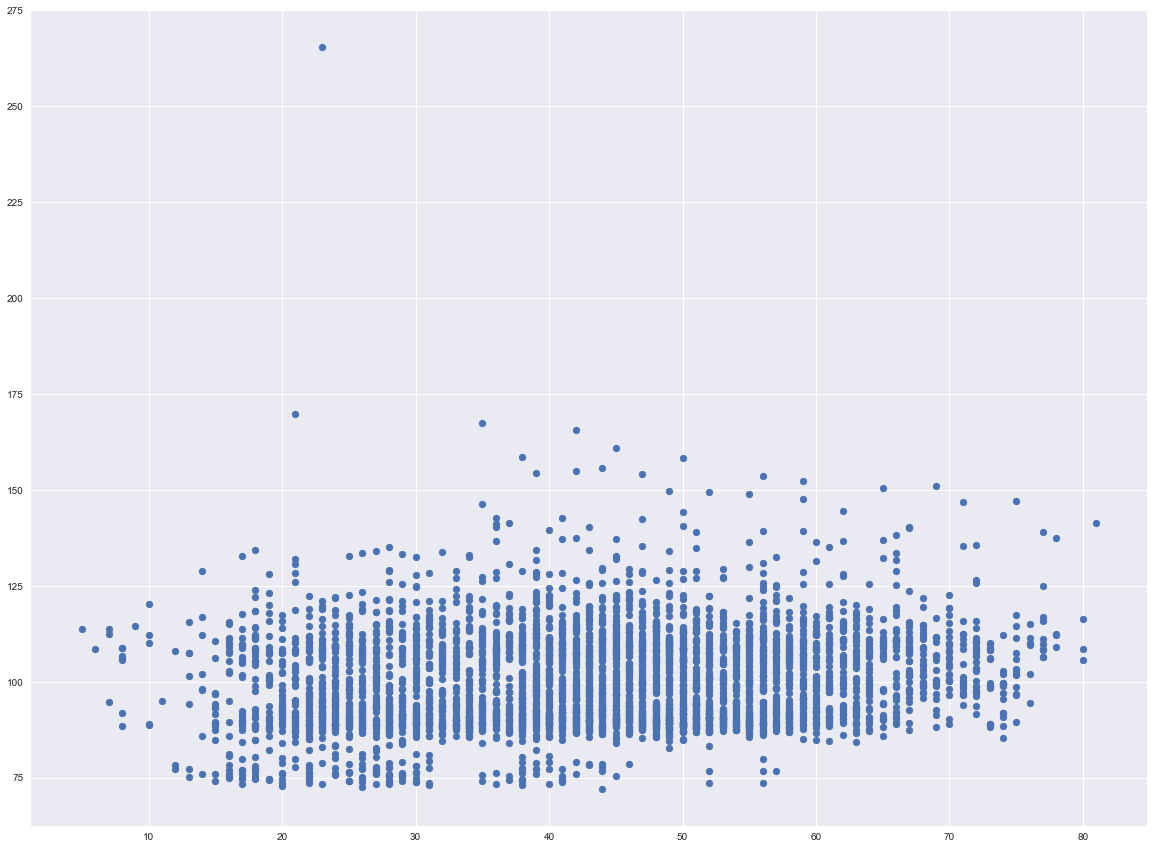

In [1915]:
metric_sort = all_data[['outlier_metric','y']].sort_values(by='outlier_metric')
metric_sort = metric_sort[metric_sort['y']>0]
plt.figure(figsize =(20,15))
plt.scatter(x=metric_sort['outlier_metric'],y=metric_sort['y'])

In [1916]:
metric_sort[metric_sort['y']>0]

,outlier_metric,y
3495,5.0,113.77
1408,6.0,108.57
333,7.0,112.49
1625,7.0,113.87
1513,7.0,94.60
4177,8.0,106.61
1868,8.0,105.64
4119,8.0,108.72
4205,8.0,108.77
1,8.0,88.53


#### encode X? variables based on sort order against y

In [1826]:
X0 = all_data['X0'].values
X0_labels = np.append(y_sort_X0, X0_testonly)
X0_labels_dict = {}
X0_values = []
label=1

for x in X0_labels:
    X0_labels_dict[x] = label
    label += 1
    
for x in X0:
    X0_values = np.append(X0_values,X0_labels_dict[x]).astype('int')
    
all_data['X0'] = X0_values

In [1827]:
X1_testonly = []
X1 = all_data['X1'].values
X1_labels = np.append(y_sort_X1, X1_testonly)
X1_labels_dict = {}
X1_values = []
label=1

for x in X1_labels:
    X1_labels_dict[x] = label
    label += 1
    
for x in X1:
    X1_values = np.append(X1_values,X1_labels_dict[x]).astype('int')
    
all_data['X1'] = X1_values

In [1828]:
X2_testonly = ['aj','ax','ab','w','ad','u']
X2 = all_data['X2'].values
X2_labels = np.append(y_sort_X2, X2_testonly)
X2_labels_dict = {}
X2_values = []
label=1

for x in X2_labels:
    X2_labels_dict[x] = label
    label += 1
    
for x in X2:
    X2_values = np.append(X2_values,X2_labels_dict[x]).astype('int')
    
all_data['X2'] = X2_values

In [1829]:
X3_testonly = []
X3 = all_data['X3'].values
X3_labels = np.append(y_sort_X3, X3_testonly)
X3_labels_dict = {}
X3_values = []
label=1

for x in X3_labels:
    X3_labels_dict[x] = label
    label += 1
    
for x in X3:
    X3_values = np.append(X3_values,X3_labels_dict[x]).astype('int')
    
all_data['X3'] = X3_values

In [1830]:
X4_testonly = []
X4 = all_data['X4'].values
X4_labels = np.append(y_sort_X4, X4_testonly)
X4_labels_dict = {}
X4_values = []
label=1

for x in X4_labels:
    X4_labels_dict[x] = label
    label += 1
    
for x in X4:
    X4_values = np.append(X4_values,X4_labels_dict[x]).astype('int')
    
all_data['X4'] = X4_values

In [1831]:
X5_testonly = ['t','b','a','z']
X5 = all_data['X5'].values
X5_labels = np.append(y_sort_X5, X5_testonly)
X5_labels_dict = {}
X5_values = []
label=1

for x in X5_labels:
    X5_labels_dict[x] = label
    label += 1
    
for x in X5:
    X5_values = np.append(X5_values,X5_labels_dict[x]).astype('int')
    
all_data['X5'] = X5_values

In [1832]:
X6_testonly = []
X6 = all_data['X6'].values
X6_labels = np.append(y_sort_X6, X6_testonly)
X6_labels_dict = {}
X6_values = []
label=1

for x in X6_labels:
    X6_labels_dict[x] = label
    label += 1
    
for x in X6:
    X6_values = np.append(X6_values,X6_labels_dict[x]).astype('int')
    
all_data['X6'] = X6_values

In [1833]:
X8_testonly = []
X8 = all_data['X8'].values
X8_labels = np.append(y_sort_X8, X8_testonly)
X8_labels_dict = {}
X8_values = []
label=1

for x in X8_labels:
    X8_labels_dict[x] = label
    label += 1
    
for x in X8:
    X8_values = np.append(X8_values,X8_labels_dict[x]).astype('int')
    
all_data['X8'] = X8_values

#### encode categorical variables

In [1919]:
## columns to encode
to_encode = ['X0','X1','X2','X3','X4','X5','X6','X8']
le = {}


for column in to_encode:
    le[column] = LabelEncoder()
    le[column].fit(all_data[column])
    all_data[column] = le[column].transform(all_data[column])

#### add more features

In [1835]:
##sum all apparent option columns to see if this is a valuable feature

#cols_to_sum = all_data.columns.values
#cols_to_sum = np.delete(cols_to_sum,list(range(0,10)))
#all_data = all_data.assign(option_sum = all_data[cols_to_sum].sum(axis=1))

In [1836]:
##Create empty column and extract index
#all_data['option_sumb'] = 'NaN'
#all_index = all_data.index.values
#all_col = all_data.columns.values[10:324]

##Gather bits into a string and add to df
#for idx in all_index:
#    gather = all_data[col][idx].astype('int').astype('str')
    
#    for col in all_col:
#        gather+=all_data[col][idx].astype('int').astype('str')
    
#    all_data['option_sumb'][idx] = gather
    
    
##Categorize it to remove any bias based on the decimal value
#le_sumb = LabelEncoder()
#le_sumb.fit(all_data['option_sumb'])
#all_data['option_sumb'] = le_sumb.transform(all_data['option_sumb'])

#### looking at gap in IDs

In [1837]:
#all_data_ID = all_data['ID']
#shift_all_data_ID = all_data_ID.drop(all_data_ID.index[0],)

#shift_ID = pd.Series([8417])
#all_data['ID_gap'] = (shift_all_data_ID.append(shift_ID, ignore_index=True) - all_data_ID)

#### drop zero variance columns

In [1920]:
##identify columns with 0 variance in train data
var_train = pd.DataFrame(train.var(),columns=['variance']).reset_index()
remove_train = var_train[var_train['variance']==0]['index'].as_matrix()

##identify columns with 0 variance in testing data
var_testing = pd.DataFrame(testing.var(),columns=['variance']).reset_index()
remove_testing = var_testing[var_testing['variance']==0]['index'].as_matrix()
##remove y from list
ind = np.argwhere(remove_testing=='y')
remove_testing = np.delete(remove_testing, ind)

##Drop columns with 0 variance in either train or test
all_data.drop(remove_train, axis=1, inplace=True)
all_data.drop(remove_testing, axis=1, inplace=True)

#### drop binary columns with low variance based on percentage of 1's or 0's

In [1839]:
#pct_threshold = .000000000001
#rows, colmns = all_data.shape

#columns = all_data.loc[:,'X10':'X384'].columns.values
#one_dict = all_data.loc[:,'X10':'X384'].sum().to_dict()

#to_drop = []

#for col in columns:
#    if one_dict[col]>(rows*(1-pct_threshold)) or one_dict[col]<(rows*pct_threshold):
#        to_drop=np.append(to_drop,col)

#all_data.drop(to_drop, axis=1, inplace=True)

#### drop duplicate columns

In [1921]:
all_data = all_data.T.drop_duplicates().T

#### complementary columns

In [1922]:
all_columns = all_data.columns.values
to_drop = []

for col in all_columns:
    
    if col in to_drop:
        continue
        
    ind = np.argwhere(all_columns==col)
    compare_columns = np.delete(all_columns, ind)
    complimentary_columns = []
    
    for comp in compare_columns:
        
        uniq = all_data[[col,comp]].sum(axis=1).nunique()
    
        if uniq==1:
            complimentary_columns.append(comp)
            to_drop.append(comp)
    #print (col, complimentary_columns,sep=':')
           
  
all_data.drop(to_drop, axis=1, inplace=True)   

#### remove highly correlated variables

In [1842]:
#corr_threshold = .8

#all_columns = all_data.columns.values
#to_drop = []

#for feat1 in all_columns:
    
#    if feat1 in to_drop:
#        continue
        
#    ind = np.argwhere(all_columns==feat1)
#    features_to_corr = np.delete(all_columns, ind)
#    correlated_features = []
    
#    for feat2 in features_to_corr:
        
#        pcorr, pvalue = pearsonr(all_data[feat1], all_data[feat2] )
    
#        if pcorr > corr_threshold:
#            to_drop.append(feat2)
#            pcorr2, pvalue2 = pearsonr(all_data[feat2], all_data['y'])
#            print (pcorr2, pvalue2, sep=':')

#    print (feat1, correlated_features, sep=':')
           
  
#all_data.drop(to_drop, axis=1, inplace=True)   

#### scale data

In [1843]:
##remove target
#all_data_Y = all_data['y']
#all_data_X = all_data.drop('y', axis=1)

#scaler = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(all_data_X)
#Scaled = pd.DataFrame(scaler.transform(all_data_X),columns=list(all_data_X))


##readd target
#Scaled['y']= all_data_Y
#all_data = Scaled

#### resplit data

In [1923]:
## resplit the data
train = all_data[0:4209]
testing = all_data[4209:].drop('y', axis=1)

## drop ID
#train.drop('ID', inplace=True, axis=1)
#testing.drop('ID', inplace=True, axis=1)

In [1845]:
#train.drop('ID', inplace=True, axis=1)
#testing.drop('ID', inplace=True, axis=1)

### Correlation

In [1846]:
def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical');
    plt.yticks(range(len(corr.columns)), corr.columns);

In [1847]:
#plot_corr(train,size=150)

In [1848]:
#pcorr = pd.DataFrame()
#for feat in train:
#    pcorr[feat] = pearsonr(train[feat], train['y'] )

#pcorr = pcorr.T
#pcorr.columns = ['corr','pvalue']
#pcorr['corr'] = abs(pcorr['corr'])
#pcorr.sort_values('corr', inplace=True, ascending=False)

In [1849]:
#top_pcorr = pcorr[:100].index.values
##remove y from list
#ind = np.argwhere(top_pcorr=='y')
#top_pcorr = np.delete(top_pcorr, ind)

In [1850]:
#top_pcorr

### Mutual information

In [1851]:
#mtrain = train.drop('y', axis=1)
#minfo = mutual_info_regression(mtrain, train.y.values)

#minfoFrame = pd.DataFrame({'feature':list(mtrain), 'minfo':minfo})
#minfoSorted = minfoFrame.sort_values(by='minfo', ascending=False)
#minfoSorted



In [1852]:
#m_top = minfoSorted.feature.values[:20]
#m_top_y = np.append(m_top,'y')
#testing = testing[m_top]
#train = train[m_top_y]


### Split out validation data

In [1853]:
#train = train.drop(train[train['y']>200].index)

In [1854]:
##feature limiting based on various methods
#top_feat_y = np.append(top_feat,'y')
#testing = testing[top_feat]
#train = train[top_feat_y]

#top_pcorr_y = np.append(top_pcorr,'y')
#testing = testing[top_pcorr]
#train = train[top_pcorr_y]

In [1855]:
#tX0mean_holding = training['X0_mean']
#vX0mean_holding = validation['X0_mean']

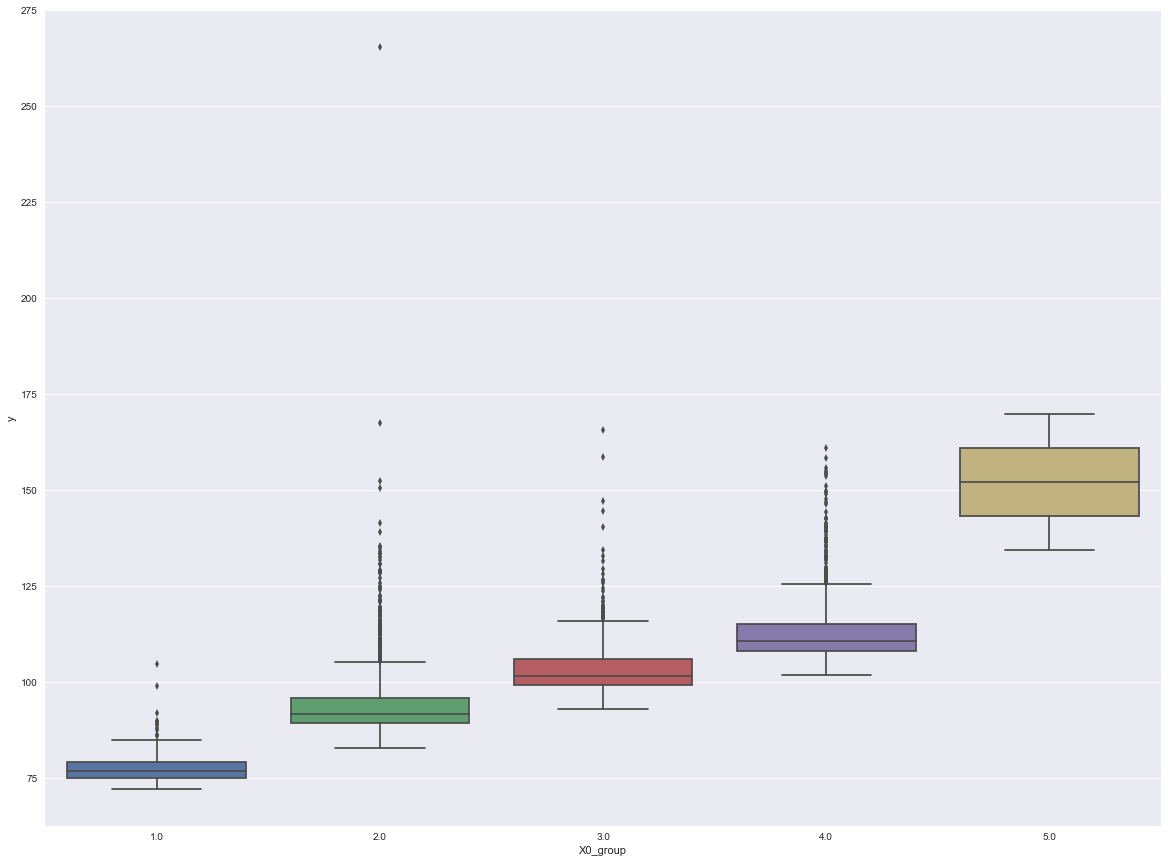

In [1856]:
plt.figure(figsize =(20,15))
ax = sns.boxplot(x="X0_group", y="y", data=train)

In [1857]:
#groups = train['X0_group'].unique()
#groups = [2]
#std_dev_thresh = 3

#for group in groups:
    
    ##initialize some variables for the group
#    grp_index = train[train['X0_group']==group].index
#    grp_std = train.loc[grp_index].y.std()
#    grp_mean = train.loc[grp_index].y.mean()
#    y_thresh = grp_mean + (std_dev_thresh * grp_std)
    
    ##squash if above threshold
#    new_y = []
#    y_values=train.loc[grp_index,'y']
    
#    for y in y_values:
#        if y > y_thresh:
#            new_y = np.append(new_y,-1)
#        else:
#            new_y = np.append(new_y,y)
#    train.loc[grp_index,'y'] = new_y
    
#keep_index = train[train['y']>0].index
#train = train.loc[keep_index]
    
    

In [1924]:
##Dived up the data into training and validation sets
training, validation = train_test_split(train, test_size = 0.1,random_state=42)

In [1859]:
#groups = training['X0_group'].unique()
#std_dev_thresh = 1.5

#for group in groups:
    
    ##initialize some variables for the group
#    grp_index = training[training['X0_group']==group].index
#    grp_std = training.loc[grp_index].y.std()
#    grp_mean = training.loc[grp_index].y.mean()
#    y_thresh = grp_mean + (std_dev_thresh * grp_std)
    
    ##squash if above threshold
#    new_y = []
#    y_values=training.loc[grp_index,'y']
    
#    for y in y_values:
#        if y > y_thresh:
#            new_y = np.append(new_y,-1)
#        else:
#            new_y = np.append(new_y,y)
#    training.loc[grp_index,'y'] = new_y
    
#keep_index = training[training['y']>0].index
#training = training.loc[keep_index]


In [1860]:
#training_outliers = training.copy()
#groups = training_outliers['X0_group'].unique()
#std_dev_thresh = 2

#for group in groups:
    
    ##initialize some variables for the group
#    grp_index = training_outliers[training_outliers['X0_group']==group].index
#    grp_std = training_outliers.loc[grp_index].y.std()
#    grp_mean = training_outliers.loc[grp_index].y.mean()
#    y_thresh = grp_mean + (std_dev_thresh * grp_std)
    
    ##create index of out outlier variables
#    new_y = []
#    y_values=training_outliers.loc[grp_index,'y']
    
#    for y in y_values:
#        if y > y_thresh:
#            new_y = np.append(new_y,y)
#        else:
#            new_y = np.append(new_y,-1)
#    training_outliers.loc[grp_index,'y'] = new_y
    
#keep_index = training_outliers[training_outliers['y']>0].index
#training_outliers = training_outliers.loc[keep_index]


In [1925]:
#to_drop = ['X0','X1','X2','X3','X4','X5','X6','X8']

training_Y = training['y']
training_X = training.drop('y', axis=1)
#training_X.drop(to_drop,axis=1,inplace=True)
#training_X.drop(['X0_mean','X2_mean'],axis=1,inplace=True)


validation_Y = validation['y']
validation_X = validation.drop('y', axis=1)
#validation_X.drop(to_drop,axis=1,inplace=True)
#validation_X.drop(['X0_mean','X2_mean'],axis=1,inplace=True)

### XGBoost

In [1926]:
##Create train and validate DMatrix
trainingXGB = xgb.DMatrix(training_X, label=training_Y)
validateXGB = xgb.DMatrix(validation_X)
testingXGB = xgb.DMatrix(testing)



### Finding best hyperparameters

In [2266]:
##Set up crossvalidation and build model to test.  
ind_params = {'nthread':3}
cv_params = {'max_depth':[2],
             'min_child_weight':[8],
             'gamma':[0],
             'subsample':[1],
             'colsample_bytree':[.9],
             'learning_rate':[.3], 
             'n_estimators':[26],
             'reg_alpha':[0]
              }
##Build optimized model with GridSearch
model_xgb = GridSearchCV(xgb.XGBRegressor(**ind_params), 
                         cv_params, 
                         cv=10, 
                         n_jobs=3,
                         verbose=100,
                         scoring='r2')

model_xgb.fit(training_X, training_Y)

best_params = model_xgb.best_params_

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to new file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int64).
Pickling array (shape=(17

[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5, score=0.587219, total=   0.3s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    1.0s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

[Parallel(n_jobs=3)]: Done  16 tasks      | elapsed:    1.9s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done  17 tasks      | elapsed:    2.0s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.635310, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.600500, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.567905, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[Parallel(n_jobs=3)]: Done  28 tasks      | elapsed:    3.0s
Pickling array (shape=(176,), dtype=object).
Pic

[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.605292, total=   0.2s
[CV] colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[Parallel(n_jobs=3)]: Done  37 tasks      | elapsed:    3.9s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

[Parallel(n_jobs=3)]: Done  46 tasks      | elapsed:    4.8s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done  47 tasks      | elapsed:    4.8s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.638155, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.600771, total=   0.2s
[CV]  colsample_bytree=0.5, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.554675, total=   0.2s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[Parallel(n_jobs=3)]: Done  58 tasks      | elapsed:    5.9s
Pickling array (shape=(176,), dtype=object).
Pickling 

[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5, score=0.588512, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[Parallel(n_jobs=3)]: Done  67 tasks      | elapsed:    6.8s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7 
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6, score=0.608215, total=   0.4s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7 
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int64).
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed:    8.2s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int6

[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.639862, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.605455, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.565831, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[Parallel(n_jobs=3)]: Done  88 tasks      | elapsed:    9.1s
Pickling array (shape=(176,), dtype=object).
Pic

[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.604392, total=   0.3s
[CV] colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[Parallel(n_jobs=3)]: Done  97 tasks      | elapsed:   10.1s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

[Parallel(n_jobs=3)]: Done 106 tasks      | elapsed:   10.9s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done 107 tasks      | elapsed:   11.0s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.606000, total=   0.2s
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.642815, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV]  colsample_bytree=0.6, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.567907, total=   0.2s
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[Parallel(n_jobs=3)]: Done 118 tasks      | elapsed:   12.1s
Pickling array (shape=(176,), dtype=object).
Pickling 

[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5, score=0.588808, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[Parallel(n_jobs=3)]: Done 127 tasks      | elapsed:   13.1s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

Pickling array (shape=(176,), dtype=object).[Parallel(n_jobs=3)]: Done 136 tasks      | elapsed:   14.0s

Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done 137 tasks      | elapsed:   14.1s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.636239, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.598316, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.563957, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[Parallel(n_jobs=3)]: Done 148 tasks      | elapsed:   15.3s
Pickling array (shape=(176,), dtype=object).
Pic

[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.607815, total=   0.3s
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[Parallel(n_jobs=3)]: Done 157 tasks      | elapsed:   16.3s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

[Parallel(n_jobs=3)]: Done 166 tasks      | elapsed:   17.3s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done 167 tasks      | elapsed:   17.3s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.633126, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.606451, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.550249, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[Parallel(n_jobs=3)]: Done 178 tasks      | elapsed:   18.5s
Pickling array (shape=(176,), dtype=object).
Pickling 

[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5, score=0.591752, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[Parallel(n_jobs=3)]: Done 187 tasks      | elapsed:   19.6s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

[Parallel(n_jobs=3)]: Done 196 tasks      | elapsed:   20.6s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done 197 tasks      | elapsed:   20.7s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7 
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int64).
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.634552, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.59762

[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.641183, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.607586, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.569030, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[Parallel(n_jobs=3)]: Done 218 tasks      | elapsed:   23.5s
Pickling array (shape=(176,), dtype=object).
Pic

[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9, score=0.641542, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9, score=0.602744, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9, score=0.569242, total=   0.3s
[Parallel(n_jobs=3)]: Done 228 tasks      | elapsed:   24.7s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01f

[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.637352, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.603255, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV]  colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.559394, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[Parallel(n_jobs=3)]: Done 238 tasks      | elapsed:   25.9s
Pickling array (shape=(176,), dtype=object).
Pickling 

[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[CV]  colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5, score=0.589782, total=   0.4s
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
Pickling array (shape=(176,), dtype=object).[Parallel(n_jobs=3)]: Done 247 tasks      | elapsed:   27.2s

Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

[Parallel(n_jobs=3)]: Done 256 tasks      | elapsed:   28.6s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done 257 tasks      | elapsed:   28.6s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV]  colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.634815, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.604556, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.562176, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[Parallel(n_jobs=3)]: Done 268 tasks      | elapsed:   30.2s
Pickling array (shape=(176,), dtype=object).
Pic

[CV]  colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.607709, total=   0.3s
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[CV] colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[Parallel(n_jobs=3)]: Done 277 tasks      | elapsed:   31.7s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int6

[Parallel(n_jobs=3)]: Done 286 tasks      | elapsed:   33.0s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done 287 tasks      | elapsed:   33.1s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV]  colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.639565, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV]  colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.603575, total=   0.3s
[CV]  colsample_bytree=0.9, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.569738, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5 
[Parallel(n_jobs=3)]: Done 298 tasks      | elapsed:   34.6s
Pickling array (shape=(176,), dtype=object).
Pickling array 

[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.5, score=0.592760, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.6 
[Parallel(n_jobs=3)]: Done 307 tasks      | elapsed:   35.7s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int64).
Pi

[Parallel(n_jobs=3)]: Done 316 tasks      | elapsed:   36.9s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3031,), dtype=int64).
Pickling array (shape=(336,), dtype=int64).
[Parallel(n_jobs=3)]: Done 317 tasks      | elapsed:   37.0s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dt

[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.628260, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.603294, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8 
[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.7, score=0.561602, total=   0.3s
[Parallel(n_jobs=3)]: Done 328 tasks      | elapsed:   38.4s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000

[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.640033, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.605902, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.8, score=0.567906, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9 
[Parallel(n_jobs=3)]: Done 338 tasks      | elapsed:   39.7s
Pickling array (shape=(176,), dtype=object).
Pickling array 

[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1 
[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=0.9, score=0.605846, total=   0.3s
[CV] colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1 
[Parallel(n_jobs=3)]: Done 347 tasks      | elapsed:   40.7s
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=int64).
Memmaping (shape=(176, 3367), dtype=float64) to old file /var/folders/9y/mr4j1gvs6g13yg_rkls01fhh0000gn/T/joblib_memmaping_pool_7660_8244103208/7660-8276198624-ccb2bd62fe8a07ac9db6a8f68a644c45.pkl
Pickling array (shape=(176,), dtype=object).
Pickling array (shape=(3367,), dtype=float64).
Pickling array (shape=(3367,), dtype=int64).
Pickling array (shape=(3030,), dtype=int64).
Pickling array (shape=(337,), dtype=int64).
[Paral

[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.604122, total=   0.3s
[CV]  colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=2, min_child_weight=8, n_estimators=26, reg_alpha=0, subsample=1, score=0.563948, total=   0.2s
[Parallel(n_jobs=3)]: Done 360 out of 360 | elapsed:   42.1s finished


In [992]:
#best_params['learning_rate'] = .01
best_params

{'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 2,
 'min_child_weight': 8,
 'n_estimators': 843,
 'reg_alpha': 0,
 'subsample': 1}

In [820]:
#best_params = {'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 2,
 'min_child_weight': 8,
 'n_estimators': 696,
 'reg_alpha': 0,
 'subsample': 1}

Looking for best number of rounds

In [991]:
##Tune booster rounds

cvresult = xgb.cv(best_params, 
                  trainingXGB, 
                  nfold=10,  
                  num_boost_round=10000, 
                  early_stopping_rounds=50,
                  metrics='rmse',
                  verbose_eval=True)




best_params['n_estimators'] = len(cvresult)

[0]	train-rmse:99.9368+0.0671726	test-rmse:99.935+0.605335
[1]	train-rmse:98.9459+0.0665503	test-rmse:98.9442+0.602535
[2]	train-rmse:97.9648+0.0660109	test-rmse:97.9632+0.599698
[3]	train-rmse:96.9936+0.0654823	test-rmse:96.992+0.596984
[4]	train-rmse:96.0322+0.0649559	test-rmse:96.0306+0.594286
[5]	train-rmse:95.0804+0.0644404	test-rmse:95.0789+0.591654
[6]	train-rmse:94.1383+0.0639311	test-rmse:94.1368+0.58908
[7]	train-rmse:93.2056+0.0634301	test-rmse:93.2042+0.586604
[8]	train-rmse:92.2823+0.0629387	test-rmse:92.2809+0.584198
[9]	train-rmse:91.3684+0.0624534	test-rmse:91.367+0.581854
[10]	train-rmse:90.4636+0.0619756	test-rmse:90.4622+0.579587
[11]	train-rmse:89.5679+0.0615025	test-rmse:89.5667+0.577409
[12]	train-rmse:88.6813+0.0610412	test-rmse:88.68+0.575269
[13]	train-rmse:87.8036+0.060588	test-rmse:87.8024+0.573199
[14]	train-rmse:86.9348+0.0601375	test-rmse:86.9336+0.571143
[15]	train-rmse:86.0747+0.0596969	test-rmse:86.0736+0.569177
[16]	train-rmse:85.2234+0.0594046	test-rm

[135]	train-rmse:27.0409+0.0586223	test-rmse:27.041+0.689993
[136]	train-rmse:26.7974+0.0590304	test-rmse:26.7974+0.693205
[137]	train-rmse:26.5565+0.0594174	test-rmse:26.5566+0.696454
[138]	train-rmse:26.3183+0.0598111	test-rmse:26.3183+0.699871
[139]	train-rmse:26.0827+0.0602137	test-rmse:26.0829+0.702976
[140]	train-rmse:25.8497+0.0606158	test-rmse:25.85+0.706362
[141]	train-rmse:25.6192+0.0610253	test-rmse:25.6195+0.7098
[142]	train-rmse:25.3913+0.0614398	test-rmse:25.3916+0.713062
[143]	train-rmse:25.1659+0.0618575	test-rmse:25.1661+0.716634
[144]	train-rmse:24.943+0.0622776	test-rmse:24.9432+0.720025
[145]	train-rmse:24.7227+0.0627017	test-rmse:24.7228+0.72343
[146]	train-rmse:24.5047+0.0631312	test-rmse:24.5047+0.727069
[147]	train-rmse:24.2892+0.0635758	test-rmse:24.2893+0.730641
[148]	train-rmse:24.076+0.0640157	test-rmse:24.0761+0.734193
[149]	train-rmse:23.8653+0.0644621	test-rmse:23.8653+0.737875
[150]	train-rmse:23.6569+0.0649083	test-rmse:23.657+0.741433
[151]	train-rmse:

[270]	train-rmse:10.6763+0.135091	test-rmse:10.6728+1.21008
[271]	train-rmse:10.6348+0.135611	test-rmse:10.6311+1.21297
[272]	train-rmse:10.5939+0.136144	test-rmse:10.5901+1.21584
[273]	train-rmse:10.5537+0.13667	test-rmse:10.55+1.21885
[274]	train-rmse:10.5141+0.137173	test-rmse:10.5104+1.22117
[275]	train-rmse:10.4751+0.137682	test-rmse:10.4713+1.22413
[276]	train-rmse:10.4368+0.138199	test-rmse:10.433+1.22692
[277]	train-rmse:10.3991+0.138694	test-rmse:10.3953+1.22982
[278]	train-rmse:10.3619+0.139195	test-rmse:10.3579+1.23266
[279]	train-rmse:10.3254+0.139675	test-rmse:10.3213+1.23523
[280]	train-rmse:10.2895+0.140167	test-rmse:10.2854+1.23798
[281]	train-rmse:10.2542+0.140646	test-rmse:10.25+1.24023
[282]	train-rmse:10.2194+0.141118	test-rmse:10.215+1.24296
[283]	train-rmse:10.1852+0.141593	test-rmse:10.1808+1.24564
[284]	train-rmse:10.1515+0.142052	test-rmse:10.1471+1.24788
[285]	train-rmse:10.1184+0.142516	test-rmse:10.1138+1.25067
[286]	train-rmse:10.0858+0.142972	test-rmse:10.

[408]	train-rmse:8.4462+0.170113	test-rmse:8.45872+1.36982
[409]	train-rmse:8.44249+0.170185	test-rmse:8.45521+1.36989
[410]	train-rmse:8.43878+0.17027	test-rmse:8.45193+1.3701
[411]	train-rmse:8.43519+0.170323	test-rmse:8.44857+1.37022
[412]	train-rmse:8.43162+0.17042	test-rmse:8.44533+1.37023
[413]	train-rmse:8.42812+0.170484	test-rmse:8.44226+1.37052
[414]	train-rmse:8.42473+0.170507	test-rmse:8.43914+1.3704
[415]	train-rmse:8.42137+0.170585	test-rmse:8.4361+1.37036
[416]	train-rmse:8.41807+0.1707	test-rmse:8.43303+1.37057
[417]	train-rmse:8.41488+0.170755	test-rmse:8.42994+1.37041
[418]	train-rmse:8.41164+0.170773	test-rmse:8.42709+1.37039
[419]	train-rmse:8.40851+0.17086	test-rmse:8.42419+1.37052
[420]	train-rmse:8.40529+0.17095	test-rmse:8.42151+1.37083
[421]	train-rmse:8.40225+0.170973	test-rmse:8.41855+1.37077
[422]	train-rmse:8.39925+0.17102	test-rmse:8.41592+1.37107
[423]	train-rmse:8.3963+0.171048	test-rmse:8.41339+1.37105
[424]	train-rmse:8.39334+0.170997	test-rmse:8.41059+

[546]	train-rmse:8.23323+0.172602	test-rmse:8.28306+1.36446
[547]	train-rmse:8.23273+0.172592	test-rmse:8.28283+1.36437
[548]	train-rmse:8.23207+0.172512	test-rmse:8.28251+1.36431
[549]	train-rmse:8.23154+0.172506	test-rmse:8.28237+1.36426
[550]	train-rmse:8.23101+0.172519	test-rmse:8.28221+1.36429
[551]	train-rmse:8.23052+0.172494	test-rmse:8.28187+1.3641
[552]	train-rmse:8.2299+0.17241	test-rmse:8.28155+1.36407
[553]	train-rmse:8.22942+0.172412	test-rmse:8.28129+1.36406
[554]	train-rmse:8.22872+0.172396	test-rmse:8.28088+1.36397
[555]	train-rmse:8.22822+0.172392	test-rmse:8.28067+1.36388
[556]	train-rmse:8.22772+0.172357	test-rmse:8.28051+1.3638
[557]	train-rmse:8.22726+0.172341	test-rmse:8.28011+1.36389
[558]	train-rmse:8.22682+0.172348	test-rmse:8.27997+1.36381
[559]	train-rmse:8.22636+0.172361	test-rmse:8.27968+1.36368
[560]	train-rmse:8.2259+0.172376	test-rmse:8.27946+1.36375
[561]	train-rmse:8.22527+0.172339	test-rmse:8.27921+1.36361
[562]	train-rmse:8.22473+0.17231	test-rmse:8.

[684]	train-rmse:8.17953+0.171265	test-rmse:8.2631+1.35687
[685]	train-rmse:8.17928+0.1713	test-rmse:8.26315+1.35686
[686]	train-rmse:8.17902+0.171276	test-rmse:8.26306+1.35699
[687]	train-rmse:8.17873+0.171258	test-rmse:8.26311+1.35695
[688]	train-rmse:8.17847+0.171236	test-rmse:8.26311+1.35689
[689]	train-rmse:8.1782+0.171256	test-rmse:8.26309+1.35682
[690]	train-rmse:8.17796+0.171247	test-rmse:8.26299+1.35684
[691]	train-rmse:8.17774+0.17127	test-rmse:8.26287+1.35697
[692]	train-rmse:8.17752+0.171254	test-rmse:8.26286+1.35699
[693]	train-rmse:8.17725+0.171373	test-rmse:8.26254+1.35632
[694]	train-rmse:8.17695+0.171344	test-rmse:8.26266+1.3563
[695]	train-rmse:8.17671+0.171326	test-rmse:8.26258+1.35633
[696]	train-rmse:8.17642+0.171355	test-rmse:8.26262+1.35634
[697]	train-rmse:8.17617+0.171325	test-rmse:8.26261+1.35636
[698]	train-rmse:8.17594+0.171332	test-rmse:8.26262+1.35631
[699]	train-rmse:8.17569+0.171354	test-rmse:8.26255+1.35642
[700]	train-rmse:8.17545+0.171394	test-rmse:8.

[822]	train-rmse:8.14601+0.170475	test-rmse:8.2606+1.35194
[823]	train-rmse:8.14579+0.170522	test-rmse:8.26062+1.35196
[824]	train-rmse:8.14552+0.170483	test-rmse:8.26068+1.35193
[825]	train-rmse:8.14531+0.170458	test-rmse:8.26068+1.3519
[826]	train-rmse:8.14501+0.170372	test-rmse:8.26076+1.35183
[827]	train-rmse:8.14483+0.1704	test-rmse:8.26073+1.35184
[828]	train-rmse:8.14461+0.170441	test-rmse:8.26072+1.35188
[829]	train-rmse:8.14441+0.170401	test-rmse:8.2608+1.35178
[830]	train-rmse:8.14415+0.170366	test-rmse:8.26082+1.35177
[831]	train-rmse:8.14394+0.170365	test-rmse:8.26086+1.35182
[832]	train-rmse:8.14374+0.170373	test-rmse:8.26092+1.35174
[833]	train-rmse:8.14356+0.170393	test-rmse:8.26086+1.3518
[834]	train-rmse:8.14336+0.170368	test-rmse:8.26073+1.3519
[835]	train-rmse:8.14316+0.170406	test-rmse:8.26073+1.35177
[836]	train-rmse:8.14296+0.170389	test-rmse:8.26067+1.35175
[837]	train-rmse:8.14273+0.170415	test-rmse:8.2608+1.35178
[838]	train-rmse:8.14253+0.170374	test-rmse:8.26

#### model testing on validation data

In [1927]:
model_xgb = xgb.train(best_params,trainingXGB, num_boost_round = best_params['n_estimators'])
predY_xgb = model_xgb.predict(validateXGB)
predY_xgb_testing = model_xgb.predict(testingXGB)

In [1928]:
r2_score((validation_Y), (predY_xgb))

0.63108410422604633

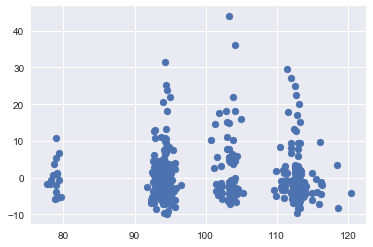

In [1929]:
residual = validation_Y-predY_xgb
#plt.scatter(y=residual, x=predY_xgb)
plt.scatter(y=residual, x=predY_xgb)

In [1930]:
residual.mean()

0.0931122696031584

In [1931]:
feat_imp = model_xgb.get_score(importance_type='gain')
importance = pd.DataFrame.from_dict(feat_imp, orient='index')
importance.columns = ['importance']
importance.sort_values(by='importance', ascending=False, inplace=True)

top_feat = importance.index[:50]


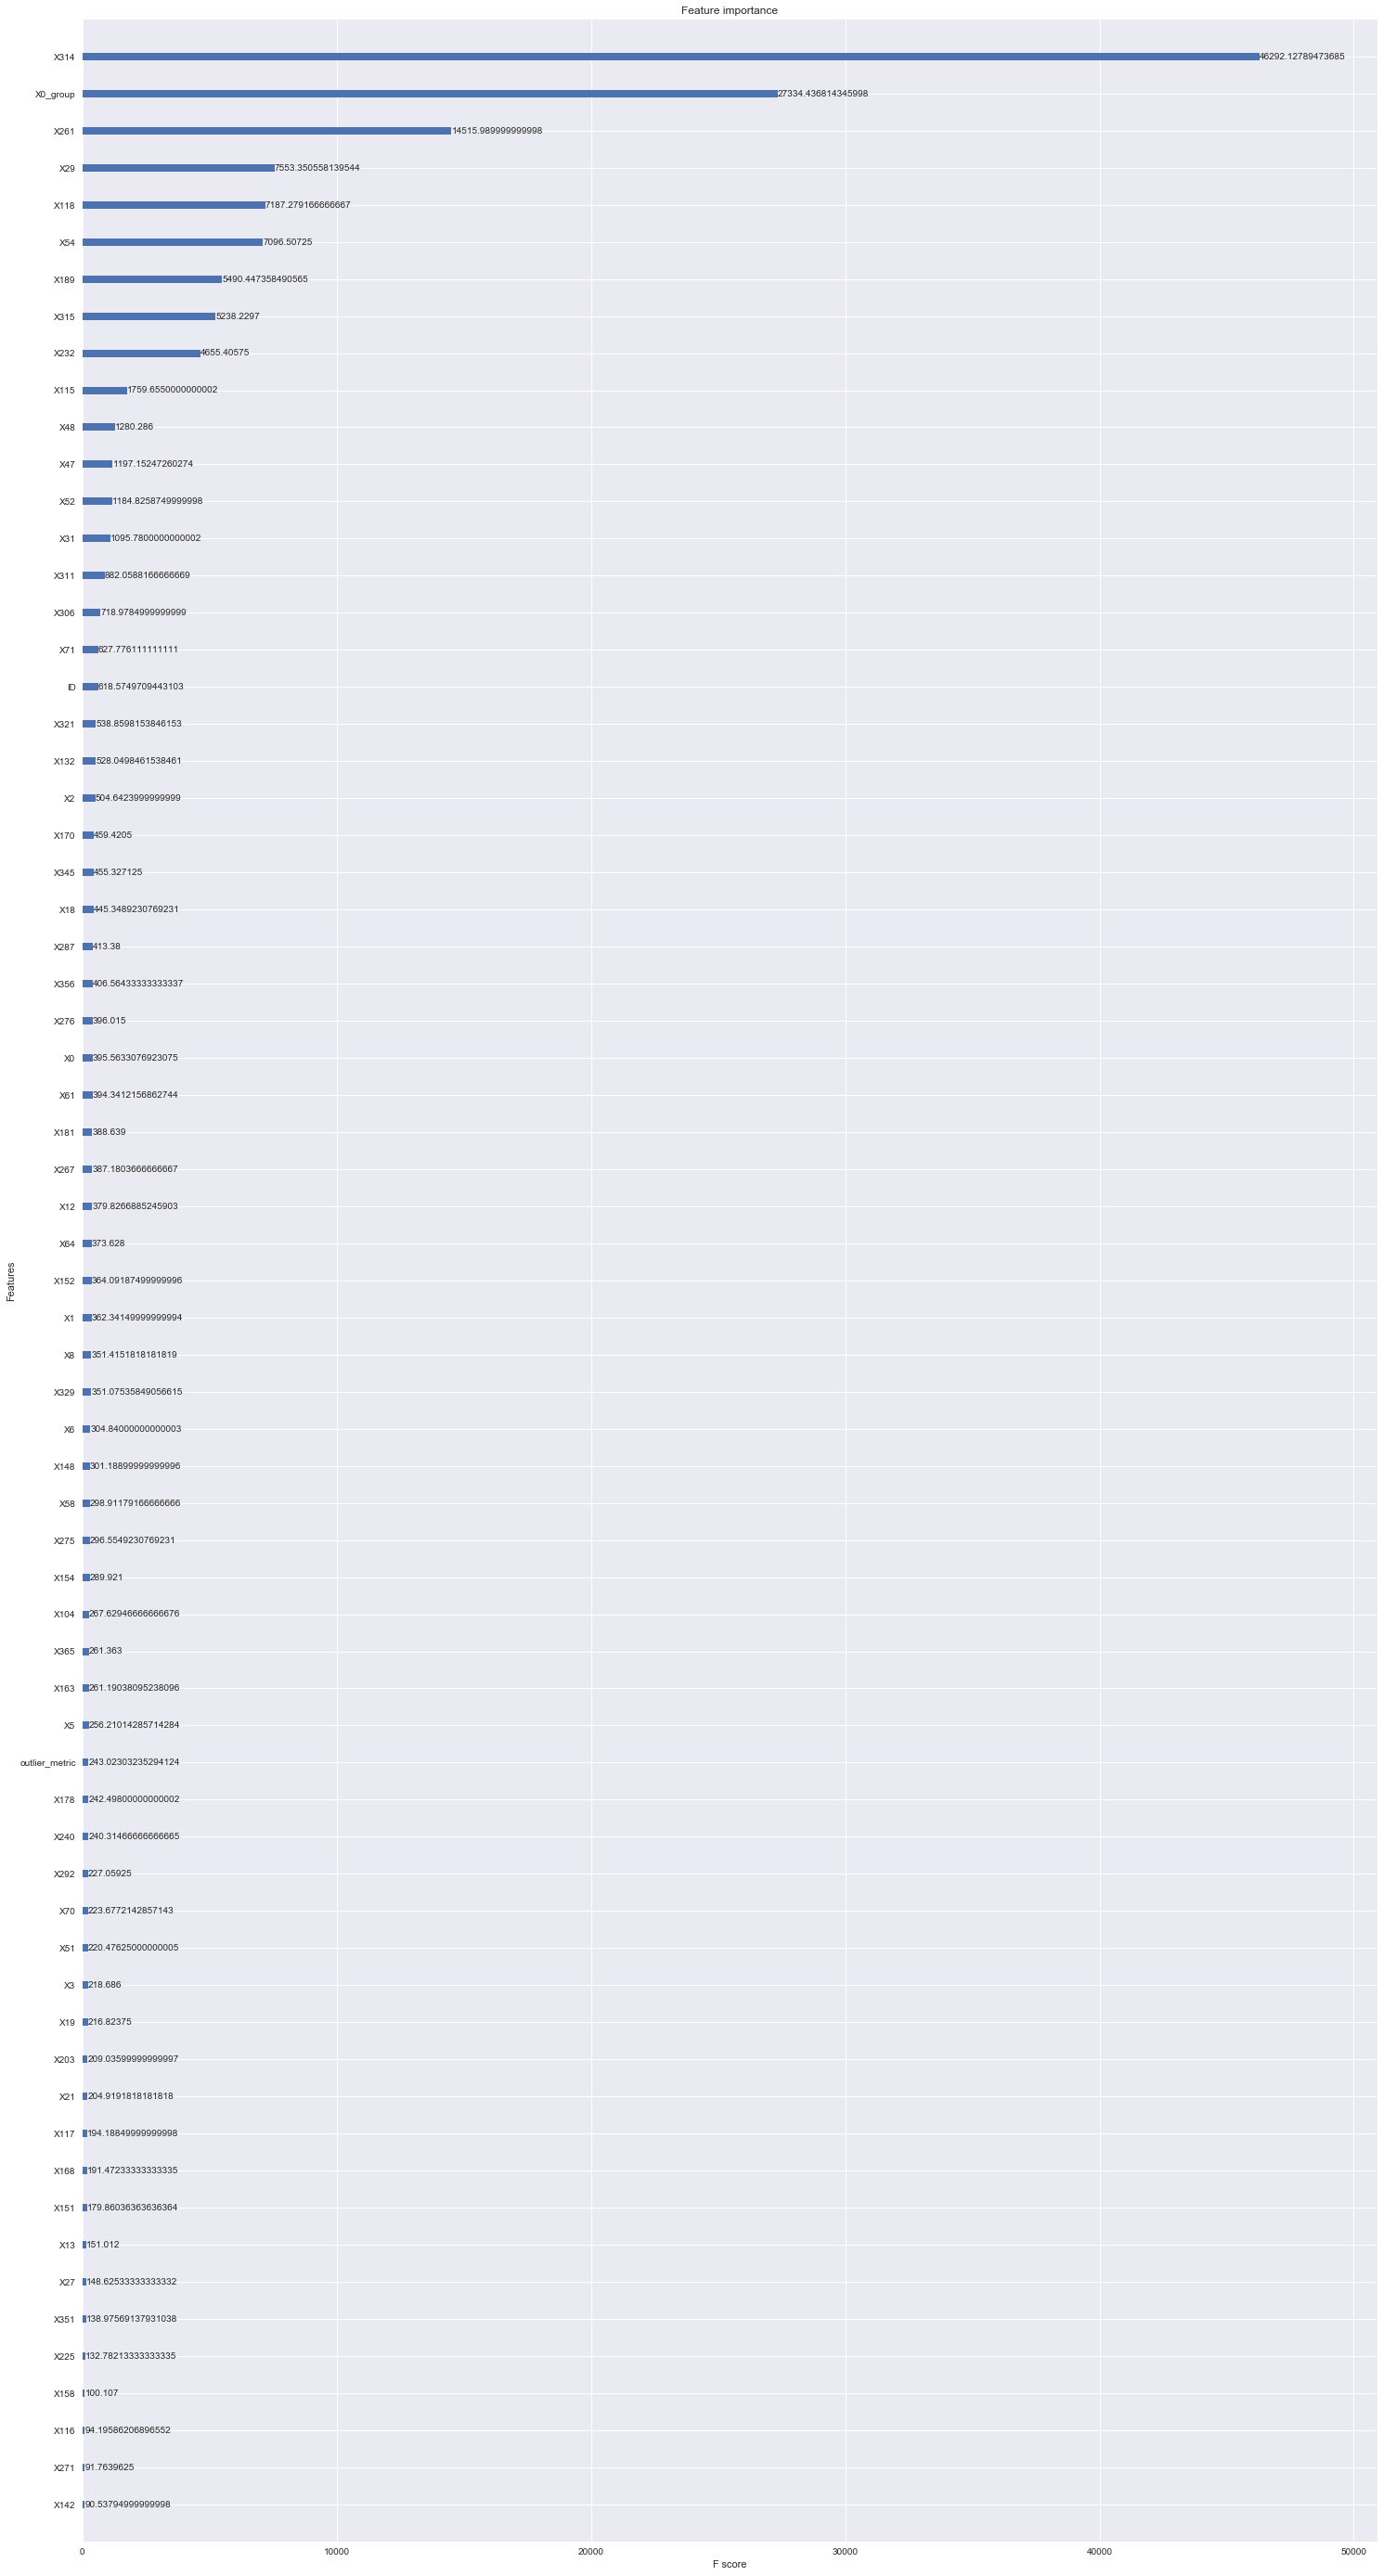

In [1932]:
fig, ax = plt.subplots(figsize=(25, 50))
xgb.plot_importance(model_xgb, ax=ax, importance_type='gain')


###  neural network

In [252]:
##Create coef of determination metric
def coeff_determination(y_true, y_pred):

    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 

    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


In [1890]:
training_Y = training['y'].values
training_X = training.drop('y', axis=1).values

validation_Y = validation['y'].values
validation_X = validation.drop('y', axis=1).values

scaler = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(training_X)
Scaled = scaler.transform(training_X)
scaled_validation_X = scaler.transform(validation_X)

rows, features = Scaled.shape

model_nn = Sequential()
model_nn.add(Dense(10, input_dim=features, activation='relu', bias_initializer='RandomNormal'))
model_nn.add(Dense(10, activation='relu', bias_initializer='RandomNormal'))
model_nn.add(Dense(10, activation='relu', bias_initializer='RandomNormal'))
model_nn.add(Dense(1, activation='linear', bias_initializer='RandomNormal'))


adamax = optimizers.adamax(lr=.0001)
model_nn.compile(loss='mean_squared_error', metrics=[coeff_determination], optimizer=adamax)

In [1891]:
weight_file = 'bestweights'
callbacks = [EarlyStopping(monitor='val_loss',patience=20, verbose=0),
            ModelCheckpoint(weight_file, verbose=0, save_best_only=True)]
model_nn.fit(Scaled, training_Y, epochs=100000, batch_size=128, validation_data=(scaled_validation_X, validation_Y), callbacks=callbacks)

Train on 3788 samples, validate on 421 samples
Epoch 1/100000
3788/3788 [==============================] - 1s - loss: 10384.9043 - coeff_determination: -66.9623 - val_loss: 10429.5301 - val_coeff_determination: -72.8311
Epoch 2/100000
3788/3788 [==============================] - 0s - loss: 10352.9129 - coeff_determination: -66.3656 - val_loss: 10402.1092 - val_coeff_determination: -72.6366
Epoch 3/100000
3788/3788 [==============================] - 0s - loss: 10329.4302 - coeff_determination: -67.3445 - val_loss: 10381.5766 - val_coeff_determination: -72.4912
Epoch 4/100000
3788/3788 [==============================] - 0s - loss: 10311.7386 - coeff_determination: -66.3860 - val_loss: 10366.2478 - val_coeff_determination: -72.3826
Epoch 5/100000
3788/3788 [==============================] - 0s - loss: 10298.2838 - coeff_determination: -65.9833 - val_loss: 10354.4931 - val_coeff_determination: -72.2994
Epoch 6/100000
3788/3788 [==============================] - 0s - loss: 10287.7887 - coef

3788/3788 [==============================] - 0s - loss: 9069.9555 - coeff_determination: -57.9916 - val_loss: 9077.4895 - val_coeff_determination: -63.2501
Epoch 49/100000
3788/3788 [==============================] - 0s - loss: 8981.2423 - coeff_determination: -57.8630 - val_loss: 8986.4389 - val_coeff_determination: -62.6050
Epoch 50/100000
3788/3788 [==============================] - 0s - loss: 8888.6733 - coeff_determination: -58.0133 - val_loss: 8891.4093 - val_coeff_determination: -61.9317
Epoch 51/100000
3788/3788 [==============================] - 0s - loss: 8792.8768 - coeff_determination: -56.5883 - val_loss: 8792.9728 - val_coeff_determination: -61.2343
Epoch 52/100000
3788/3788 [==============================] - 0s - loss: 8693.5925 - coeff_determination: -55.0464 - val_loss: 8691.1735 - val_coeff_determination: -60.5130
Epoch 53/100000
3788/3788 [==============================] - 0s - loss: 8590.9030 - coeff_determination: -54.9747 - val_loss: 8585.5845 - val_coeff_determin

3788/3788 [==============================] - 0s - loss: 2193.1520 - coeff_determination: -13.3255 - val_loss: 2103.1554 - val_coeff_determination: -13.8522
Epoch 96/100000
3788/3788 [==============================] - 0s - loss: 2031.5291 - coeff_determination: -12.1110 - val_loss: 1941.4582 - val_coeff_determination: -12.7077
Epoch 97/100000
3788/3788 [==============================] - 0s - loss: 1874.0789 - coeff_determination: -10.9801 - val_loss: 1785.6177 - val_coeff_determination: -11.6048
Epoch 98/100000
3788/3788 [==============================] - 0s - loss: 1721.7340 - coeff_determination: -10.0458 - val_loss: 1633.8692 - val_coeff_determination: -10.5309
Epoch 99/100000
3788/3788 [==============================] - 0s - loss: 1574.7458 - coeff_determination: -9.0401 - val_loss: 1488.3273 - val_coeff_determination: -9.5011
Epoch 100/100000
3788/3788 [==============================] - 0s - loss: 1433.5308 - coeff_determination: -8.3133 - val_loss: 1349.2439 - val_coeff_determinat

3788/3788 [==============================] - 0s - loss: 222.1901 - coeff_determination: -0.3822 - val_loss: 193.0759 - val_coeff_determination: -0.3576
Epoch 144/100000
3788/3788 [==============================] - 0s - loss: 220.5199 - coeff_determination: -0.3767 - val_loss: 191.4598 - val_coeff_determination: -0.3462
Epoch 145/100000
3788/3788 [==============================] - 0s - loss: 218.8459 - coeff_determination: -0.3719 - val_loss: 189.8336 - val_coeff_determination: -0.3348
Epoch 146/100000
3788/3788 [==============================] - 0s - loss: 217.1461 - coeff_determination: -0.3658 - val_loss: 188.2647 - val_coeff_determination: -0.3238
Epoch 147/100000
3788/3788 [==============================] - 0s - loss: 215.4594 - coeff_determination: -0.3411 - val_loss: 186.6846 - val_coeff_determination: -0.3127
Epoch 148/100000
3788/3788 [==============================] - 0s - loss: 213.7876 - coeff_determination: -0.3398 - val_loss: 185.0666 - val_coeff_determination: -0.3013
Epo

3788/3788 [==============================] - 0s - loss: 149.9991 - coeff_determination: 0.0717 - val_loss: 125.0273 - val_coeff_determination: 0.1200
Epoch 192/100000
3788/3788 [==============================] - 0s - loss: 148.7808 - coeff_determination: 0.0829 - val_loss: 123.9364 - val_coeff_determination: 0.1275
Epoch 193/100000
3788/3788 [==============================] - 0s - loss: 147.6379 - coeff_determination: 0.0916 - val_loss: 122.8390 - val_coeff_determination: 0.1352
Epoch 194/100000
3788/3788 [==============================] - 0s - loss: 146.4819 - coeff_determination: 0.0959 - val_loss: 121.7885 - val_coeff_determination: 0.1427
Epoch 195/100000
3788/3788 [==============================] - 0s - loss: 145.2907 - coeff_determination: 0.1042 - val_loss: 120.7392 - val_coeff_determination: 0.1500
Epoch 196/100000
3788/3788 [==============================] - 0s - loss: 144.1709 - coeff_determination: 0.1112 - val_loss: 119.7228 - val_coeff_determination: 0.1572
Epoch 197/10000

3788/3788 [==============================] - 0s - loss: 107.9430 - coeff_determination: 0.3387 - val_loss: 87.0236 - val_coeff_determination: 0.3867
Epoch 241/100000
3788/3788 [==============================] - 0s - loss: 107.4056 - coeff_determination: 0.3459 - val_loss: 86.5460 - val_coeff_determination: 0.3901
Epoch 242/100000
3788/3788 [==============================] - 0s - loss: 106.8771 - coeff_determination: 0.3470 - val_loss: 86.0815 - val_coeff_determination: 0.3933
Epoch 243/100000
3788/3788 [==============================] - 0s - loss: 106.3538 - coeff_determination: 0.3549 - val_loss: 85.6119 - val_coeff_determination: 0.3967
Epoch 244/100000
3788/3788 [==============================] - 0s - loss: 105.8157 - coeff_determination: 0.3627 - val_loss: 85.1441 - val_coeff_determination: 0.3999
Epoch 245/100000
3788/3788 [==============================] - 0s - loss: 105.2973 - coeff_determination: 0.3636 - val_loss: 84.6679 - val_coeff_determination: 0.4033
Epoch 246/100000
3788

3788/3788 [==============================] - 0s - loss: 89.8472 - coeff_determination: 0.4578 - val_loss: 71.1964 - val_coeff_determination: 0.4989
Epoch 290/100000
3788/3788 [==============================] - 0s - loss: 89.6129 - coeff_determination: 0.4572 - val_loss: 71.0370 - val_coeff_determination: 0.5000
Epoch 291/100000
3788/3788 [==============================] - 0s - loss: 89.3973 - coeff_determination: 0.4601 - val_loss: 70.8249 - val_coeff_determination: 0.5015
Epoch 292/100000
3788/3788 [==============================] - 0s - loss: 89.1846 - coeff_determination: 0.4678 - val_loss: 70.6431 - val_coeff_determination: 0.5028
Epoch 293/100000
3788/3788 [==============================] - 0s - loss: 89.0090 - coeff_determination: 0.4626 - val_loss: 70.4754 - val_coeff_determination: 0.5040
Epoch 294/100000
3788/3788 [==============================] - 0s - loss: 88.7832 - coeff_determination: 0.4676 - val_loss: 70.2978 - val_coeff_determination: 0.5053
Epoch 295/100000
3788/3788 

3788/3788 [==============================] - 0s - loss: 82.9421 - coeff_determination: 0.5029 - val_loss: 65.3981 - val_coeff_determination: 0.5403
Epoch 339/100000
3788/3788 [==============================] - 0s - loss: 82.8529 - coeff_determination: 0.5100 - val_loss: 65.3228 - val_coeff_determination: 0.5409
Epoch 340/100000
3788/3788 [==============================] - 0s - loss: 82.7294 - coeff_determination: 0.5036 - val_loss: 65.2412 - val_coeff_determination: 0.5415
Epoch 341/100000
3788/3788 [==============================] - 0s - loss: 82.6532 - coeff_determination: 0.5127 - val_loss: 65.1630 - val_coeff_determination: 0.5420
Epoch 342/100000
3788/3788 [==============================] - 0s - loss: 82.5768 - coeff_determination: 0.5048 - val_loss: 65.0546 - val_coeff_determination: 0.5428
Epoch 343/100000
3788/3788 [==============================] - 0s - loss: 82.4373 - coeff_determination: 0.5086 - val_loss: 65.0146 - val_coeff_determination: 0.5431
Epoch 344/100000
3788/3788 

3788/3788 [==============================] - 0s - loss: 79.2220 - coeff_determination: 0.5321 - val_loss: 62.3176 - val_coeff_determination: 0.5623
Epoch 388/100000
3788/3788 [==============================] - 0s - loss: 79.1705 - coeff_determination: 0.5333 - val_loss: 62.2825 - val_coeff_determination: 0.5626
Epoch 389/100000
3788/3788 [==============================] - 0s - loss: 79.1364 - coeff_determination: 0.5320 - val_loss: 62.2612 - val_coeff_determination: 0.5627
Epoch 390/100000
3788/3788 [==============================] - 0s - loss: 79.0635 - coeff_determination: 0.5296 - val_loss: 62.1977 - val_coeff_determination: 0.5632
Epoch 391/100000
3788/3788 [==============================] - 0s - loss: 79.0255 - coeff_determination: 0.5304 - val_loss: 62.1836 - val_coeff_determination: 0.5633
Epoch 392/100000
3788/3788 [==============================] - 0s - loss: 78.9708 - coeff_determination: 0.5302 - val_loss: 62.1380 - val_coeff_determination: 0.5636
Epoch 393/100000
3788/3788 

3788/3788 [==============================] - 0s - loss: 76.9594 - coeff_determination: 0.5473 - val_loss: 60.4741 - val_coeff_determination: 0.5755
Epoch 437/100000
3788/3788 [==============================] - 0s - loss: 76.9251 - coeff_determination: 0.5477 - val_loss: 60.4687 - val_coeff_determination: 0.5755
Epoch 438/100000
3788/3788 [==============================] - 0s - loss: 76.8798 - coeff_determination: 0.5433 - val_loss: 60.4126 - val_coeff_determination: 0.5759
Epoch 439/100000
3788/3788 [==============================] - 0s - loss: 76.8541 - coeff_determination: 0.5467 - val_loss: 60.3825 - val_coeff_determination: 0.5762
Epoch 440/100000
3788/3788 [==============================] - 0s - loss: 76.8028 - coeff_determination: 0.5471 - val_loss: 60.3672 - val_coeff_determination: 0.5763
Epoch 441/100000
3788/3788 [==============================] - 0s - loss: 76.7741 - coeff_determination: 0.5423 - val_loss: 60.3398 - val_coeff_determination: 0.5765
Epoch 442/100000
3788/3788 

3788/3788 [==============================] - 0s - loss: 75.4238 - coeff_determination: 0.5523 - val_loss: 59.3420 - val_coeff_determination: 0.5836
Epoch 486/100000
3788/3788 [==============================] - 0s - loss: 75.4016 - coeff_determination: 0.5477 - val_loss: 59.3229 - val_coeff_determination: 0.5837
Epoch 487/100000
3788/3788 [==============================] - 0s - loss: 75.3917 - coeff_determination: 0.5553 - val_loss: 59.2853 - val_coeff_determination: 0.5840
Epoch 488/100000
3788/3788 [==============================] - 0s - loss: 75.3428 - coeff_determination: 0.5551 - val_loss: 59.2735 - val_coeff_determination: 0.5841
Epoch 489/100000
3788/3788 [==============================] - 0s - loss: 75.3284 - coeff_determination: 0.5548 - val_loss: 59.2704 - val_coeff_determination: 0.5841
Epoch 490/100000
3788/3788 [==============================] - 0s - loss: 75.2902 - coeff_determination: 0.5598 - val_loss: 59.2509 - val_coeff_determination: 0.5842
Epoch 491/100000
3788/3788 

3788/3788 [==============================] - 0s - loss: 74.2448 - coeff_determination: 0.5606 - val_loss: 58.5024 - val_coeff_determination: 0.5895
Epoch 535/100000
3788/3788 [==============================] - 0s - loss: 74.2059 - coeff_determination: 0.5646 - val_loss: 58.4906 - val_coeff_determination: 0.5896
Epoch 536/100000
3788/3788 [==============================] - 0s - loss: 74.1967 - coeff_determination: 0.5689 - val_loss: 58.4788 - val_coeff_determination: 0.5897
Epoch 537/100000
3788/3788 [==============================] - 0s - loss: 74.1633 - coeff_determination: 0.5632 - val_loss: 58.4679 - val_coeff_determination: 0.5898
Epoch 538/100000
3788/3788 [==============================] - 0s - loss: 74.1455 - coeff_determination: 0.5582 - val_loss: 58.4606 - val_coeff_determination: 0.5898
Epoch 539/100000
3788/3788 [==============================] - 0s - loss: 74.1150 - coeff_determination: 0.5611 - val_loss: 58.4434 - val_coeff_determination: 0.5900
Epoch 540/100000
3788/3788 

3788/3788 [==============================] - 0s - loss: 73.2628 - coeff_determination: 0.5676 - val_loss: 57.9044 - val_coeff_determination: 0.5938
Epoch 584/100000
3788/3788 [==============================] - 0s - loss: 73.2449 - coeff_determination: 0.5758 - val_loss: 57.8761 - val_coeff_determination: 0.5940
Epoch 585/100000
3788/3788 [==============================] - 0s - loss: 73.2259 - coeff_determination: 0.5728 - val_loss: 57.8711 - val_coeff_determination: 0.5940
Epoch 586/100000
3788/3788 [==============================] - 0s - loss: 73.2027 - coeff_determination: 0.5714 - val_loss: 57.8653 - val_coeff_determination: 0.5940
Epoch 587/100000
3788/3788 [==============================] - 0s - loss: 73.1894 - coeff_determination: 0.5709 - val_loss: 57.8611 - val_coeff_determination: 0.5941
Epoch 588/100000
3788/3788 [==============================] - 0s - loss: 73.1761 - coeff_determination: 0.5699 - val_loss: 57.8526 - val_coeff_determination: 0.5941
Epoch 589/100000
3788/3788 

3788/3788 [==============================] - 0s - loss: 72.4769 - coeff_determination: 0.5689 - val_loss: 57.4674 - val_coeff_determination: 0.5968
Epoch 633/100000
3788/3788 [==============================] - 0s - loss: 72.4553 - coeff_determination: 0.5704 - val_loss: 57.4733 - val_coeff_determination: 0.5968
Epoch 634/100000
3788/3788 [==============================] - 0s - loss: 72.4446 - coeff_determination: 0.5738 - val_loss: 57.4532 - val_coeff_determination: 0.5969
Epoch 635/100000
3788/3788 [==============================] - 0s - loss: 72.4224 - coeff_determination: 0.5690 - val_loss: 57.4489 - val_coeff_determination: 0.5969
Epoch 636/100000
3788/3788 [==============================] - 0s - loss: 72.4291 - coeff_determination: 0.5739 - val_loss: 57.4428 - val_coeff_determination: 0.5970
Epoch 637/100000
3788/3788 [==============================] - 0s - loss: 72.4429 - coeff_determination: 0.5762 - val_loss: 57.4374 - val_coeff_determination: 0.5970
Epoch 638/100000
3788/3788 

3788/3788 [==============================] - 0s - loss: 71.8249 - coeff_determination: 0.5765 - val_loss: 57.1576 - val_coeff_determination: 0.5990
Epoch 682/100000
3788/3788 [==============================] - 0s - loss: 71.8146 - coeff_determination: 0.5739 - val_loss: 57.1504 - val_coeff_determination: 0.5990
Epoch 683/100000
3788/3788 [==============================] - 0s - loss: 71.8015 - coeff_determination: 0.5785 - val_loss: 57.1453 - val_coeff_determination: 0.5990
Epoch 684/100000
3788/3788 [==============================] - 0s - loss: 71.7969 - coeff_determination: 0.5724 - val_loss: 57.1486 - val_coeff_determination: 0.5990
Epoch 685/100000
3788/3788 [==============================] - 0s - loss: 71.7784 - coeff_determination: 0.5857 - val_loss: 57.1328 - val_coeff_determination: 0.5991
Epoch 686/100000
3788/3788 [==============================] - 0s - loss: 71.7750 - coeff_determination: 0.5783 - val_loss: 57.1352 - val_coeff_determination: 0.5991
Epoch 687/100000
3788/3788 

3788/3788 [==============================] - 0s - loss: 71.3033 - coeff_determination: 0.5821 - val_loss: 56.9381 - val_coeff_determination: 0.6005
Epoch 731/100000
3788/3788 [==============================] - 0s - loss: 71.2788 - coeff_determination: 0.5789 - val_loss: 56.9408 - val_coeff_determination: 0.6005
Epoch 732/100000
3788/3788 [==============================] - 0s - loss: 71.2871 - coeff_determination: 0.5824 - val_loss: 56.9298 - val_coeff_determination: 0.6005
Epoch 733/100000
3788/3788 [==============================] - 0s - loss: 71.2921 - coeff_determination: 0.5784 - val_loss: 56.9287 - val_coeff_determination: 0.6005
Epoch 734/100000
3788/3788 [==============================] - 0s - loss: 71.2729 - coeff_determination: 0.5782 - val_loss: 56.9252 - val_coeff_determination: 0.6006
Epoch 735/100000
3788/3788 [==============================] - 0s - loss: 71.2549 - coeff_determination: 0.5795 - val_loss: 56.9189 - val_coeff_determination: 0.6006
Epoch 736/100000
3788/3788 

3788/3788 [==============================] - 0s - loss: 70.8189 - coeff_determination: 0.5846 - val_loss: 56.7483 - val_coeff_determination: 0.6018
Epoch 780/100000
3788/3788 [==============================] - 0s - loss: 70.8099 - coeff_determination: 0.5836 - val_loss: 56.7547 - val_coeff_determination: 0.6017
Epoch 781/100000
3788/3788 [==============================] - 0s - loss: 70.8165 - coeff_determination: 0.5793 - val_loss: 56.7411 - val_coeff_determination: 0.6018
Epoch 782/100000
3788/3788 [==============================] - 0s - loss: 70.8097 - coeff_determination: 0.5828 - val_loss: 56.7277 - val_coeff_determination: 0.6019
Epoch 783/100000
3788/3788 [==============================] - 0s - loss: 70.8259 - coeff_determination: 0.5849 - val_loss: 56.7412 - val_coeff_determination: 0.6018
Epoch 784/100000
3788/3788 [==============================] - 0s - loss: 70.8244 - coeff_determination: 0.5810 - val_loss: 56.7503 - val_coeff_determination: 0.6017
Epoch 785/100000
3788/3788 

3788/3788 [==============================] - 0s - loss: 70.4045 - coeff_determination: 0.5880 - val_loss: 56.5672 - val_coeff_determination: 0.6030
Epoch 829/100000
3788/3788 [==============================] - 0s - loss: 70.3968 - coeff_determination: 0.5819 - val_loss: 56.5579 - val_coeff_determination: 0.6030
Epoch 830/100000
3788/3788 [==============================] - 0s - loss: 70.3765 - coeff_determination: 0.5814 - val_loss: 56.5699 - val_coeff_determination: 0.6029
Epoch 831/100000
3788/3788 [==============================] - 0s - loss: 70.4087 - coeff_determination: 0.5838 - val_loss: 56.5658 - val_coeff_determination: 0.6030
Epoch 832/100000
3788/3788 [==============================] - 0s - loss: 70.3578 - coeff_determination: 0.5921 - val_loss: 56.5674 - val_coeff_determination: 0.6030
Epoch 833/100000
3788/3788 [==============================] - 0s - loss: 70.3532 - coeff_determination: 0.5823 - val_loss: 56.5634 - val_coeff_determination: 0.6030
Epoch 834/100000
3788/3788 

3788/3788 [==============================] - 0s - loss: 70.0356 - coeff_determination: 0.5847 - val_loss: 56.4627 - val_coeff_determination: 0.6036
Epoch 878/100000
3788/3788 [==============================] - 0s - loss: 70.0350 - coeff_determination: 0.5872 - val_loss: 56.4685 - val_coeff_determination: 0.6036
Epoch 879/100000
3788/3788 [==============================] - 0s - loss: 70.0193 - coeff_determination: 0.5854 - val_loss: 56.4708 - val_coeff_determination: 0.6036
Epoch 880/100000
3788/3788 [==============================] - 0s - loss: 70.0115 - coeff_determination: 0.5828 - val_loss: 56.4670 - val_coeff_determination: 0.6036
Epoch 881/100000
3788/3788 [==============================] - 0s - loss: 70.0622 - coeff_determination: 0.5865 - val_loss: 56.4844 - val_coeff_determination: 0.6035
Epoch 882/100000
3788/3788 [==============================] - 0s - loss: 69.9987 - coeff_determination: 0.5925 - val_loss: 56.4690 - val_coeff_determination: 0.6036
Epoch 883/100000
3788/3788 

3788/3788 [==============================] - 0s - loss: 69.7068 - coeff_determination: 0.5913 - val_loss: 56.3789 - val_coeff_determination: 0.6042
Epoch 927/100000
3788/3788 [==============================] - 0s - loss: 69.7093 - coeff_determination: 0.5879 - val_loss: 56.3805 - val_coeff_determination: 0.6042
Epoch 928/100000
3788/3788 [==============================] - 0s - loss: 69.7097 - coeff_determination: 0.5882 - val_loss: 56.3577 - val_coeff_determination: 0.6043
Epoch 929/100000
3788/3788 [==============================] - 0s - loss: 69.6934 - coeff_determination: 0.5873 - val_loss: 56.3874 - val_coeff_determination: 0.6041
Epoch 930/100000
3788/3788 [==============================] - 0s - loss: 69.6960 - coeff_determination: 0.5928 - val_loss: 56.3560 - val_coeff_determination: 0.6043
Epoch 931/100000
3788/3788 [==============================] - 0s - loss: 69.6744 - coeff_determination: 0.5907 - val_loss: 56.3595 - val_coeff_determination: 0.6043
Epoch 932/100000
3788/3788 

3788/3788 [==============================] - 0s - loss: 69.4199 - coeff_determination: 0.5897 - val_loss: 56.2970 - val_coeff_determination: 0.6047
Epoch 976/100000
3788/3788 [==============================] - 0s - loss: 69.4094 - coeff_determination: 0.5968 - val_loss: 56.2907 - val_coeff_determination: 0.6047
Epoch 977/100000
3788/3788 [==============================] - 0s - loss: 69.4091 - coeff_determination: 0.5887 - val_loss: 56.2897 - val_coeff_determination: 0.6048
Epoch 978/100000
3788/3788 [==============================] - 0s - loss: 69.3926 - coeff_determination: 0.5878 - val_loss: 56.2784 - val_coeff_determination: 0.6048
Epoch 979/100000
3788/3788 [==============================] - 0s - loss: 69.4164 - coeff_determination: 0.5877 - val_loss: 56.3123 - val_coeff_determination: 0.6046
Epoch 980/100000
3788/3788 [==============================] - 0s - loss: 69.3831 - coeff_determination: 0.5888 - val_loss: 56.2766 - val_coeff_determination: 0.6048
Epoch 981/100000
3788/3788 

3788/3788 [==============================] - 0s - loss: 69.1717 - coeff_determination: 0.5921 - val_loss: 56.2272 - val_coeff_determination: 0.6051
Epoch 1025/100000
3788/3788 [==============================] - 0s - loss: 69.1639 - coeff_determination: 0.5967 - val_loss: 56.2275 - val_coeff_determination: 0.6051
Epoch 1026/100000
3788/3788 [==============================] - 0s - loss: 69.1388 - coeff_determination: 0.5849 - val_loss: 56.2227 - val_coeff_determination: 0.6052
Epoch 1027/100000
3788/3788 [==============================] - 0s - loss: 69.1389 - coeff_determination: 0.5928 - val_loss: 56.2193 - val_coeff_determination: 0.6052
Epoch 1028/100000
3788/3788 [==============================] - 0s - loss: 69.1332 - coeff_determination: 0.5901 - val_loss: 56.2284 - val_coeff_determination: 0.6051
Epoch 1029/100000
3788/3788 [==============================] - 0s - loss: 69.1516 - coeff_determination: 0.5930 - val_loss: 56.2235 - val_coeff_determination: 0.6052
Epoch 1030/100000
3788

3788/3788 [==============================] - 0s - loss: 68.9241 - coeff_determination: 0.5999 - val_loss: 56.2029 - val_coeff_determination: 0.6053
Epoch 1074/100000
3788/3788 [==============================] - 0s - loss: 68.9045 - coeff_determination: 0.5972 - val_loss: 56.1832 - val_coeff_determination: 0.6054
Epoch 1075/100000
3788/3788 [==============================] - 0s - loss: 68.8918 - coeff_determination: 0.5950 - val_loss: 56.1869 - val_coeff_determination: 0.6054
Epoch 1076/100000
3788/3788 [==============================] - 0s - loss: 68.8985 - coeff_determination: 0.5961 - val_loss: 56.1826 - val_coeff_determination: 0.6054
Epoch 1077/100000
3788/3788 [==============================] - 0s - loss: 68.8879 - coeff_determination: 0.5908 - val_loss: 56.2055 - val_coeff_determination: 0.6052
Epoch 1078/100000
3788/3788 [==============================] - 0s - loss: 68.8791 - coeff_determination: 0.5940 - val_loss: 56.1842 - val_coeff_determination: 0.6054
Epoch 1079/100000
3788

3788/3788 [==============================] - 0s - loss: 68.7004 - coeff_determination: 0.5914 - val_loss: 56.1397 - val_coeff_determination: 0.6056
Epoch 1123/100000
3788/3788 [==============================] - 0s - loss: 68.6999 - coeff_determination: 0.5934 - val_loss: 56.1230 - val_coeff_determination: 0.6058
Epoch 1124/100000
3788/3788 [==============================] - 0s - loss: 68.6967 - coeff_determination: 0.5973 - val_loss: 56.1291 - val_coeff_determination: 0.6057
Epoch 1125/100000
3788/3788 [==============================] - 0s - loss: 68.6771 - coeff_determination: 0.5946 - val_loss: 56.1276 - val_coeff_determination: 0.6057
Epoch 1126/100000
3788/3788 [==============================] - 0s - loss: 68.6916 - coeff_determination: 0.5967 - val_loss: 56.1357 - val_coeff_determination: 0.6057
Epoch 1127/100000
3788/3788 [==============================] - 0s - loss: 68.6700 - coeff_determination: 0.5945 - val_loss: 56.1203 - val_coeff_determination: 0.6058
Epoch 1128/100000
3788

3788/3788 [==============================] - 0s - loss: 68.5267 - coeff_determination: 0.5975 - val_loss: 56.0726 - val_coeff_determination: 0.6061
Epoch 1172/100000
3788/3788 [==============================] - 0s - loss: 68.4869 - coeff_determination: 0.5943 - val_loss: 56.0718 - val_coeff_determination: 0.6061
Epoch 1173/100000
3788/3788 [==============================] - 0s - loss: 68.4898 - coeff_determination: 0.5926 - val_loss: 56.0764 - val_coeff_determination: 0.6060
Epoch 1174/100000
3788/3788 [==============================] - 0s - loss: 68.4813 - coeff_determination: 0.5948 - val_loss: 56.0858 - val_coeff_determination: 0.6060
Epoch 1175/100000
3788/3788 [==============================] - 0s - loss: 68.4838 - coeff_determination: 0.5950 - val_loss: 56.0539 - val_coeff_determination: 0.6062
Epoch 1176/100000
3788/3788 [==============================] - 0s - loss: 68.4804 - coeff_determination: 0.5950 - val_loss: 56.1049 - val_coeff_determination: 0.6058
Epoch 1177/100000
3788

In [1459]:
model_nn.load_weights(weight_file, by_name=False)
predY_nn = model_nn.predict(scaled_validation_X, batch_size=128)


r2_score(validation_Y, predY_nn)

0.60970747150565319

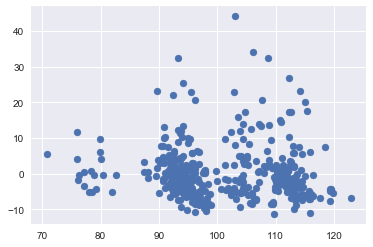

In [1460]:
residual = validation_Y-predY_nn[:,0]
#plt.scatter(y=validation_Y, x=predY_nn[:,0])
plt.scatter(y=residual, x=predY_nn[:,0])

In [1461]:
residual.mean()

0.072988826362084314

#### Linear regression

In [1933]:
model_lm = linear_model.Lasso(alpha=.01, normalize=True, fit_intercept=False, max_iter=100000)
model_lm.fit(training_X,training_Y)

Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=100000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [1934]:
predY_lm = model_lm.predict(validation_X)
predY_lm_testing = model_lm.predict(testing)
r2_score(validation_Y, predY_lm)

0.60928426411181713

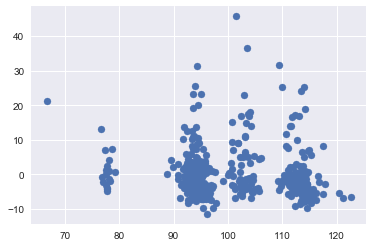

In [1935]:
residual = validation_Y-predY_lm
#plt.scatter(y=validation_Y, x=predY_lm)
plt.scatter(y=residual, x=predY_lm)

In [1936]:
residual.mean()

0.19457139182615144

#### elastic net

In [1937]:
model_elastic = linear_model.ElasticNet(alpha=.01, normalize=True, fit_intercept=False, max_iter=100000)
model_elastic.fit(training_X,training_Y)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=False, l1_ratio=0.5,
      max_iter=100000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [1938]:
predY_elastic = model_elastic.predict(validation_X)
predY_elastic_testing = model_elastic.predict(testing)
r2_score(validation_Y, predY_elastic)

0.61652582061490846

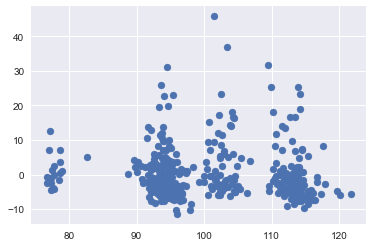

In [1939]:
residual = validation_Y-predY_elastic
#plt.scatter(y=validation_Y, x=predY_elastic)
plt.scatter(y=residual, x=predY_elastic)

In [1940]:
residual.mean()

0.18096903868609474

#### random forest

In [1941]:
model_rf = RandomForestRegressor(n_jobs=3, n_estimators=1700, max_depth=8, max_features='sqrt', min_samples_leaf=1, random_state=15)
model_rf.fit(training_X, training_Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1700, n_jobs=3, oob_score=False, random_state=15,
           verbose=0, warm_start=False)

In [1942]:
predY_rf = model_rf.predict(validation_X)
predY_rf_testing = model_rf.predict(testing)
r2_score(validation_Y, predY_rf)

0.61622479233557392

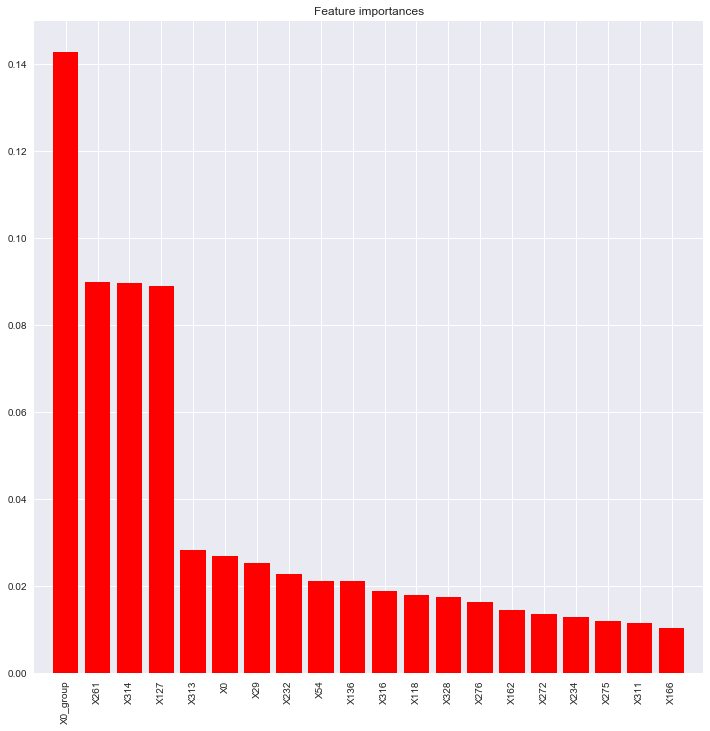

In [1943]:
feat_names = training_X.columns.values
## plot the importances ##
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

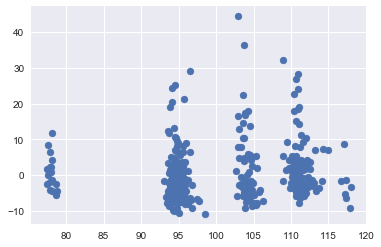

In [1944]:
residual = validation_Y-predY_rf
#plt.scatter(y=validation_Y, x=predY_rf)
plt.scatter(y=residual, x=predY_rf)

In [1945]:
residual.mean()

0.1060653747019507

#### PCA with ridge

In [1946]:
n_components = [50, 75, 85, 100, 110, 125, 135, 150]
alpha = [.1, .2, .3]
#normalize=True, fit_intercept=False, max_iter=100000


pipe_dict = dict(pca__n_components=n_components,
                linear__alpha=alpha,
                linear__max_iter=[1000000])


regr = linear_model.Lasso()
pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('linear', regr)])

model_pca_lasso = GridSearchCV(pipe,pipe_dict, cv=10)

model_pca_lasso.fit(training_X, training_Y)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [50, 75, 85, 100, 110, 125, 135, 150], 'linear__alpha': [0.1, 0.2, 0.3], 'linear__max_iter': [1000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [1947]:
model_pca_lasso.best_estimator_.named_steps['pca'].n_components

75

In [1948]:
model_pca_lasso.best_estimator_.named_steps['linear'].alpha

0.1

In [1949]:
predY_pca_lasso = model_pca_lasso.predict(validation_X)
predY_pca_lasso_testing = model_pca_lasso.predict(testing)
r2_score(validation_Y, predY_pca_lasso)

0.61511354687322217

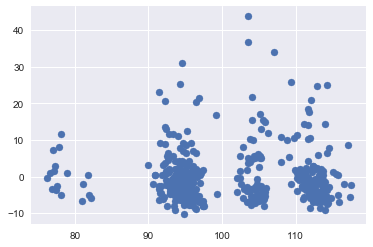

In [1950]:
residual = validation_Y-predY_pca_lasso
plt.scatter(y=residual, x=predY_pca_lasso)

In [1951]:
residual.mean()

-0.03323675843673948

In [1952]:
predY_combo = (predY_xgb + predY_rf + 3*predY_pca_lasso)/5
r2_score(validation_Y, predY_combo)

0.6232906425262732

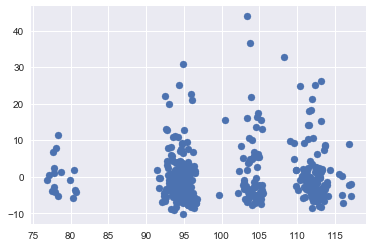

In [1953]:
residual = validation_Y-predY_combo
#plt.scatter(y=validation_Y, x=predY_combo)
plt.scatter(y=residual, x=predY_combo)

In [1954]:
residual.mean()

0.019893473798978538

### Final and submission

In [885]:
train_final_Y = train['y']
train_final_X = train.drop('y',axis=1)
#train_final_X.drop(to_drop,axis=1,inplace=True)
#train_final_X = train[top10]
#testing_final = testing[top10]
testing_final = testing
#testing_final.drop(to_drop,axis=1,inplace=True)

#### nerual net sub

In [4369]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(train_final_X.values)
Scaled = scaler.transform(train_final_X.values)
scaled_testing = scaler.transform(testing_final.values)



rows, features = train_final_X.shape

model_nn_final = Sequential()
model_nn_final.add(Dense(features, input_dim=features, activation='relu', bias_initializer='RandomNormal'))
model_nn_final.add(Dense(10, activation='relu', bias_initializer='RandomNormal'))
model_nn_final.add(Dense(10, activation='relu', bias_initializer='RandomNormal'))
model_nn_final.add(Dense(1, activation='linear', bias_initializer='RandomNormal'))

model_nn_final.compile(loss='mean_squared_error', metrics=[coeff_determination], optimizer='adamax')

model_nn_final.load_weights(weight_file, by_name=False)

predY_nn_final = model_nn.predict(scaled_testing, batch_size=128)

In [4370]:
submission_nn = pd.DataFrame()
submission_nn['ID'] = testing['ID'].astype('int')
submission_nn['y'] = predY_nn_final


sub_file_nn = 'submission-nn.csv'
submission_nn.to_csv(sub_file_nn, index=False)

#### lm sub

In [226]:
model_lm_final = linear_model.Lasso(alpha=.01, normalize=True, fit_intercept=False, max_iter=100000)
model_lm_final.fit(train_final_X,train_final_Y)

Lasso(alpha=0.01, copy_X=True, fit_intercept=False, max_iter=100000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [227]:
predY_lm_final = model_lm_final.predict(testing_final)

submission_lm = pd.DataFrame()
submission_lm['ID'] = testing_ID
submission_lm['y'] = predY_lm_final

sub_file_lm = 'submission-lasso.csv'
submission_lm.to_csv(sub_file_lm, index=False)


#### elastic net

In [228]:
model_elastic_final = linear_model.ElasticNet(alpha=.01, normalize=True, fit_intercept=False, max_iter=100000)
model_elastic_final.fit(train_final_X,train_final_Y)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=False, l1_ratio=0.5,
      max_iter=100000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [229]:
predY_elastic_final = model_elastic_final.predict(testing_final)

submission_elastic = pd.DataFrame()
submission_elastic['ID'] = testing_ID
submission_elastic['y'] = predY_elastic_final

sub_file_elastic = 'submission-elastic.csv'
submission_elastic.to_csv(sub_file_elastic, index=False)

#### svm sub

In [230]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(train_final_X)
Scaled_final = pd.DataFrame(scaler.transform(train_final_X),columns=list(train_final_X))
scaled_testing = pd.DataFrame(scaler.transform(testing_final),columns=list(train_final_X))


model_svm_final = svm.SVR(kernel='rbf', C=550, epsilon=0, max_iter=1000000)
model_svm_final.fit(Scaled_final,train_final_Y)

SVR(C=550, cache_size=200, coef0=0.0, degree=3, epsilon=0, gamma='auto',
  kernel='rbf', max_iter=1000000, shrinking=True, tol=0.001, verbose=False)

In [231]:
predY_svm_final = model_svm_final.predict(scaled_testing)

submission_svm = pd.DataFrame()
submission_svm['ID'] = testing_ID
submission_svm['y'] = predY_svm_final



#### random forest sub

In [232]:
model_rf_final = RandomForestRegressor(n_jobs=3, n_estimators=3000, max_depth=9, max_features='sqrt', min_samples_leaf=1)
model_rf_final.fit(train_final_X, train_final_Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=3000, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [233]:
predY_rf_final = model_rf_final.predict(testing_final)

submission_rf = pd.DataFrame()
submission_rf['ID'] = testing_ID
submission_rf['y'] = predY_rf_final

#### pca with lasso final

In [234]:
model_pca_lasso_final = GridSearchCV(pipe,pipe_dict, cv=5)

model_pca_lasso_final.fit(train_final_X, train_final_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [5, 10, 15, 30, 50], 'linear__alpha': [0.1, 0.5, 1, 3, 5], 'linear__max_iter': [1000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [235]:
predY_pca_lasso_final = model_pca_lasso_final.predict(testing_final)

submission_pca_lasso = pd.DataFrame()
submission_pca_lasso['ID'] = testing_ID
submission_pca_lasso['y'] = predY_pca_lasso_final


sub_file_pca_lasso = 'submission-pca_lasso.csv'
submission_pca_lasso.to_csv(sub_file_pca_lasso, index=False)

#### xgboost sub

In [236]:
trainXGB = xgb.DMatrix(train_final_X, label=train_final_Y)
testingXGB = xgb.DMatrix(testing_final)

model_xgb_final = xgb.train(best_params,trainXGB, num_boost_round = best_params['n_estimators'])

predY_xgb_final = model_xgb_final.predict(testingXGB)



submission_xgb = pd.DataFrame()
submission_xgb['ID'] = testing_ID
submission_xgb['y'] = predY_xgb_final



sub_file_xgb = 'submission-xgb.csv'
submission_xgb.to_csv(sub_file_xgb, index=False)

#### combined submission

In [237]:
submission_combo = pd.DataFrame()
submission_combo['ID'] = testing_ID
submission_combo['y_xgb'] = submission_xgb['y']
submission_combo['y_lm'] = submission_lm['y']
submission_combo['y_elastic'] = submission_elastic['y']
submission_combo['y_svm'] = submission_svm['y']
submission_combo['y_rf'] = submission_rf['y']
submission_combo['y_pca_lasso'] = submission_pca_lasso['y']

submission_combo['y'] = (submission_combo.y_xgb.values+\
                         submission_combo.y_lm.values+\
                         submission_combo.y_rf.values+\
                         submission_combo.y_pca_lasso.values+\
                         submission_combo.y_elastic.values+\
                         submission_combo.y_svm.values)/6
#submission_combo['y_combo'] = np.cbrt((submission_combo.y.values*submission_combo.y_lm.values*submission_combo.y_pca_lasso.values))

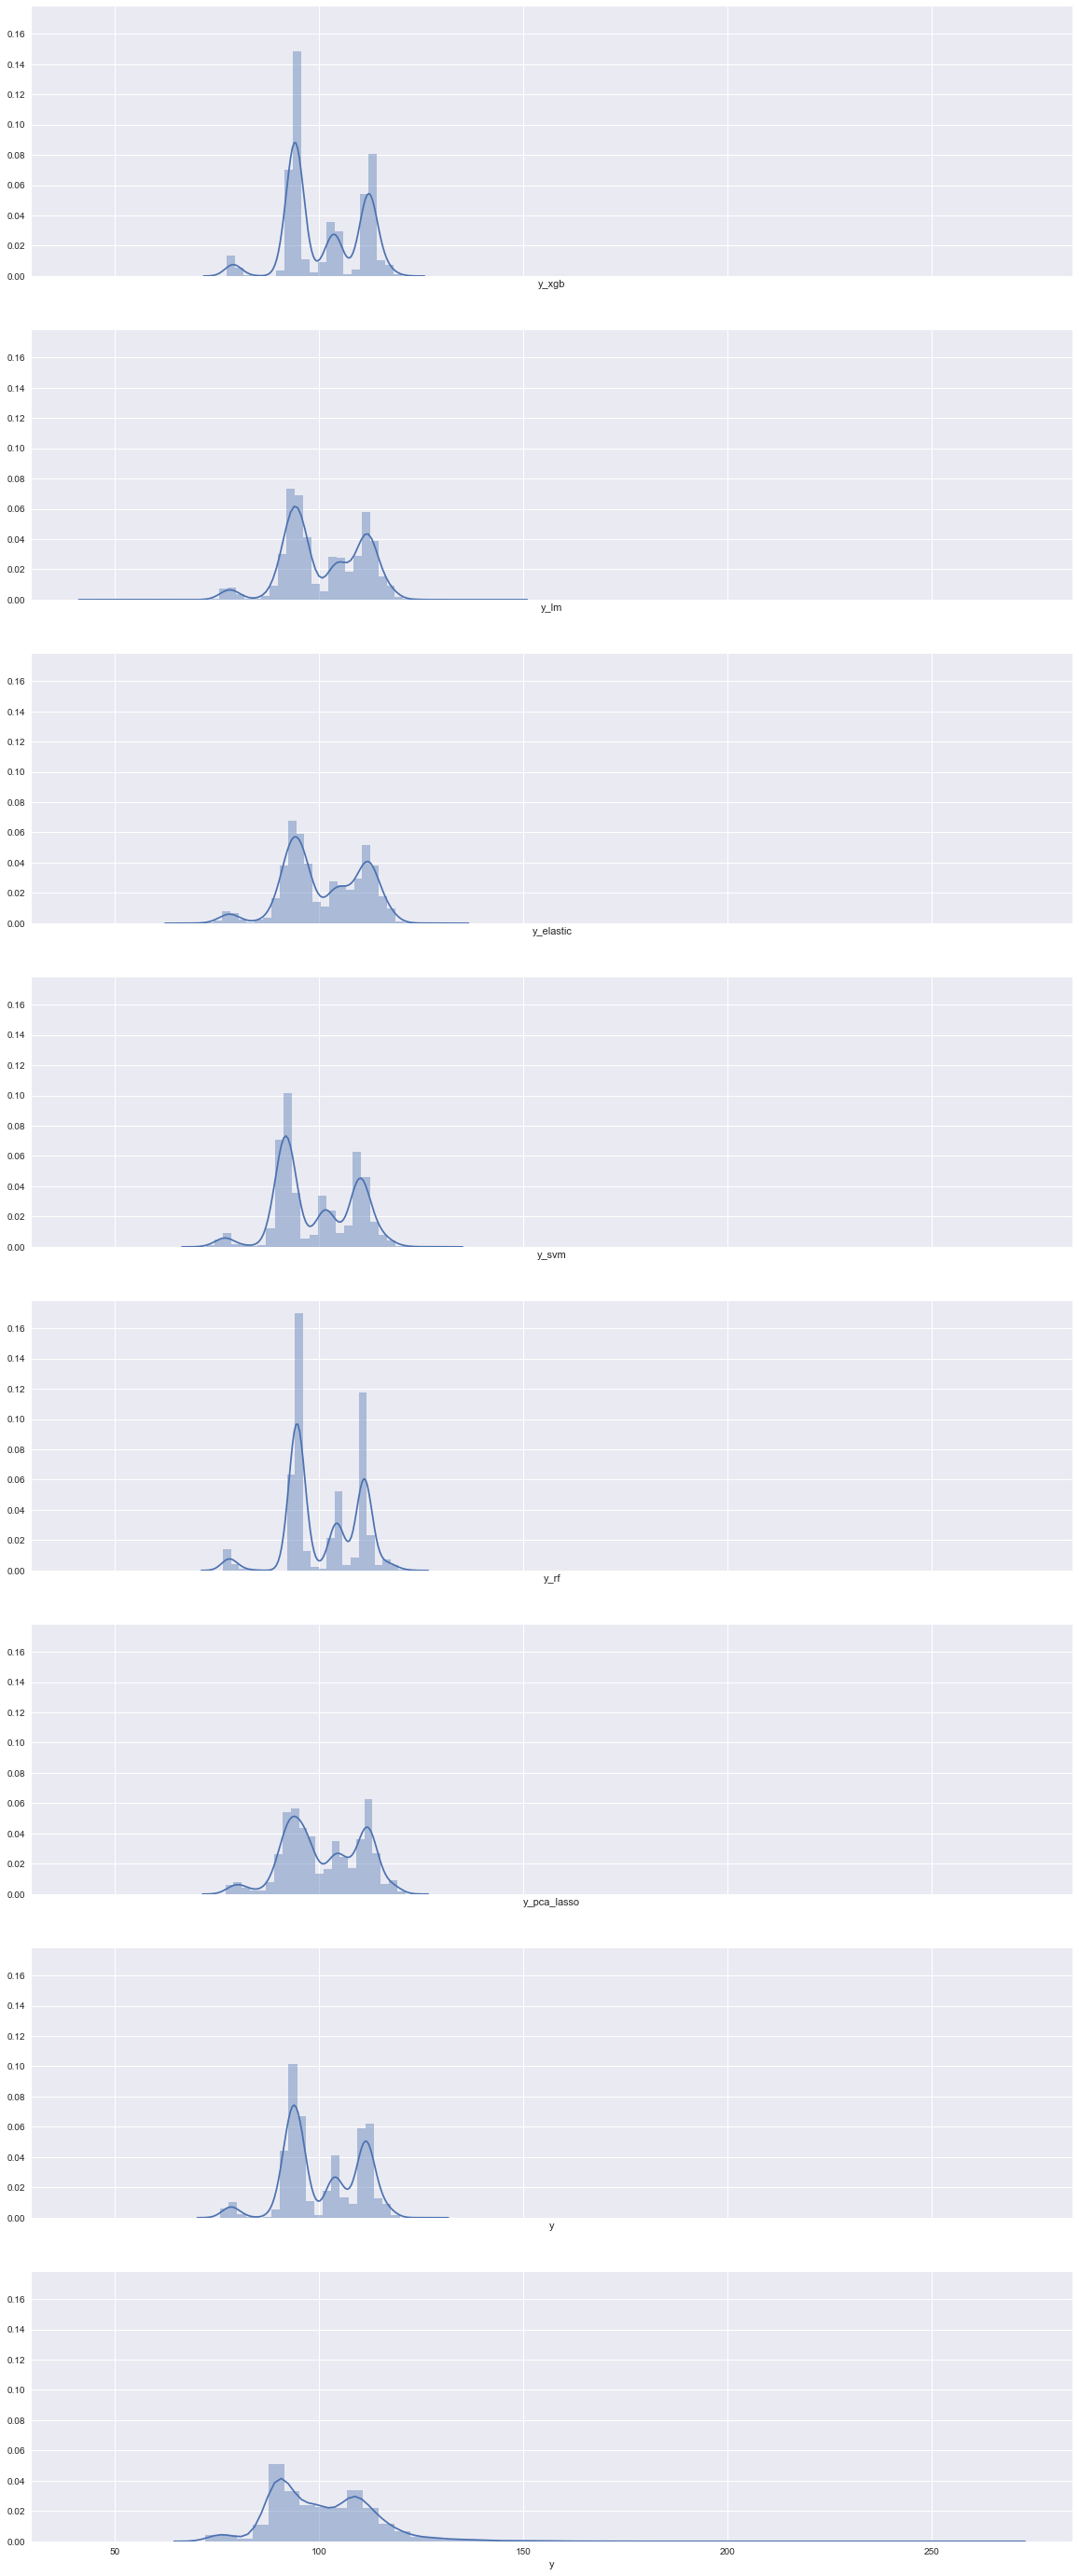

In [238]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(nrows=8, sharex=True, sharey=True, figsize=(20,50))
sns.distplot(submission_combo['y_xgb'], ax=ax1)
sns.distplot(submission_combo['y_lm'], ax=ax2)
sns.distplot(submission_combo['y_elastic'],ax=ax3)
sns.distplot(submission_combo['y_svm'],ax=ax4)
sns.distplot(submission_combo['y_rf'],ax=ax5)
sns.distplot(submission_combo['y_pca_lasso'],ax=ax6)
sns.distplot(submission_combo['y'],ax=ax7)
sns.distplot(train['y'],ax=ax8)

In [240]:
submission_combo.drop(['y_xgb','y_lm','y_elastic','y_rf','y_svm','y_pca_lasso'], axis=1, inplace=True)
submission_combo.rename(columns={'y_combo': 'y'}, inplace=True)


sub_file_combo = 'submission_combo.csv'
submission_combo.to_csv(sub_file_combo, index=False)

### Blending

In [1958]:
predictions_B = pd.DataFrame()
predictions_B['xgb'] = predY_xgb
predictions_B['rf'] = predY_rf
#predictions_B['elastic'] = predY_elastic
#predictions_B['lm'] = predY_lm
predictions_B['pca_lasso'] = predY_pca_lasso
predictions_B['y'] = validation_Y.values

predictions_C = pd.DataFrame()
predictions_C['xgb'] = predY_xgb_testing
predictions_C['rf'] = predY_rf_testing
#predictions_C['elastic'] = predY_elastic_testing
#predictions_C['lm'] = predY_lm_testing
predictions_C['pca_lasso'] = predY_pca_lasso_testing



In [1959]:
model_lm_blend = linear_model.LinearRegression()
model_lm_blend.fit(predictions_B.drop('y',axis=1), predictions_B['y'])
predY_blend_lm = model_lm_blend.predict(predictions_C)

In [1955]:
predY_combo_final = (predY_xgb_testing + predY_rf_testing + 3*predY_pca_lasso_testing)/5

In [1960]:
submission_blend = pd.DataFrame()
submission_blend['ID'] = testing_ID
submission_blend['y'] = predY_blend_lm



sub_file_blend = 'submission-blend.csv'
submission_blend.to_csv(sub_file_blend, index=False)

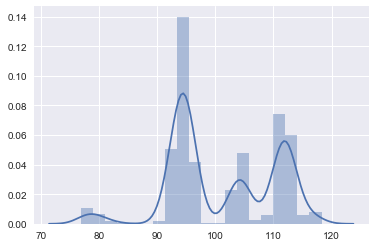

In [1957]:
sns.distplot(predY_combo_final)